In [2]:
import pandas as pd
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from scipy.stats import gaussian_kde, kendalltau
from plotly.subplots import make_subplots
from typing import Tuple
import os
import plotly.express as px
import plotly.graph_objects as go

# Part 1

In [3]:
data = load_dataset()

## Point a

In [4]:
log_returns = compute_daily_returns(df=data, log_returns=True, dropna=True)
linear_returns = compute_daily_returns(df=data, log_returns=False, dropna=True)

In [5]:
fig = go.Figure()

for col in log_returns.columns:
    fig.add_trace(go.Scatter(
        x=log_returns.index,
        y=log_returns[col],
        mode='lines',
        name=col
    ))

fig.update_layout(
    title="Stock Returns Over Time",
    xaxis_title="Date",
    yaxis_title="Returns",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()

#### Analysis with Daily Returns

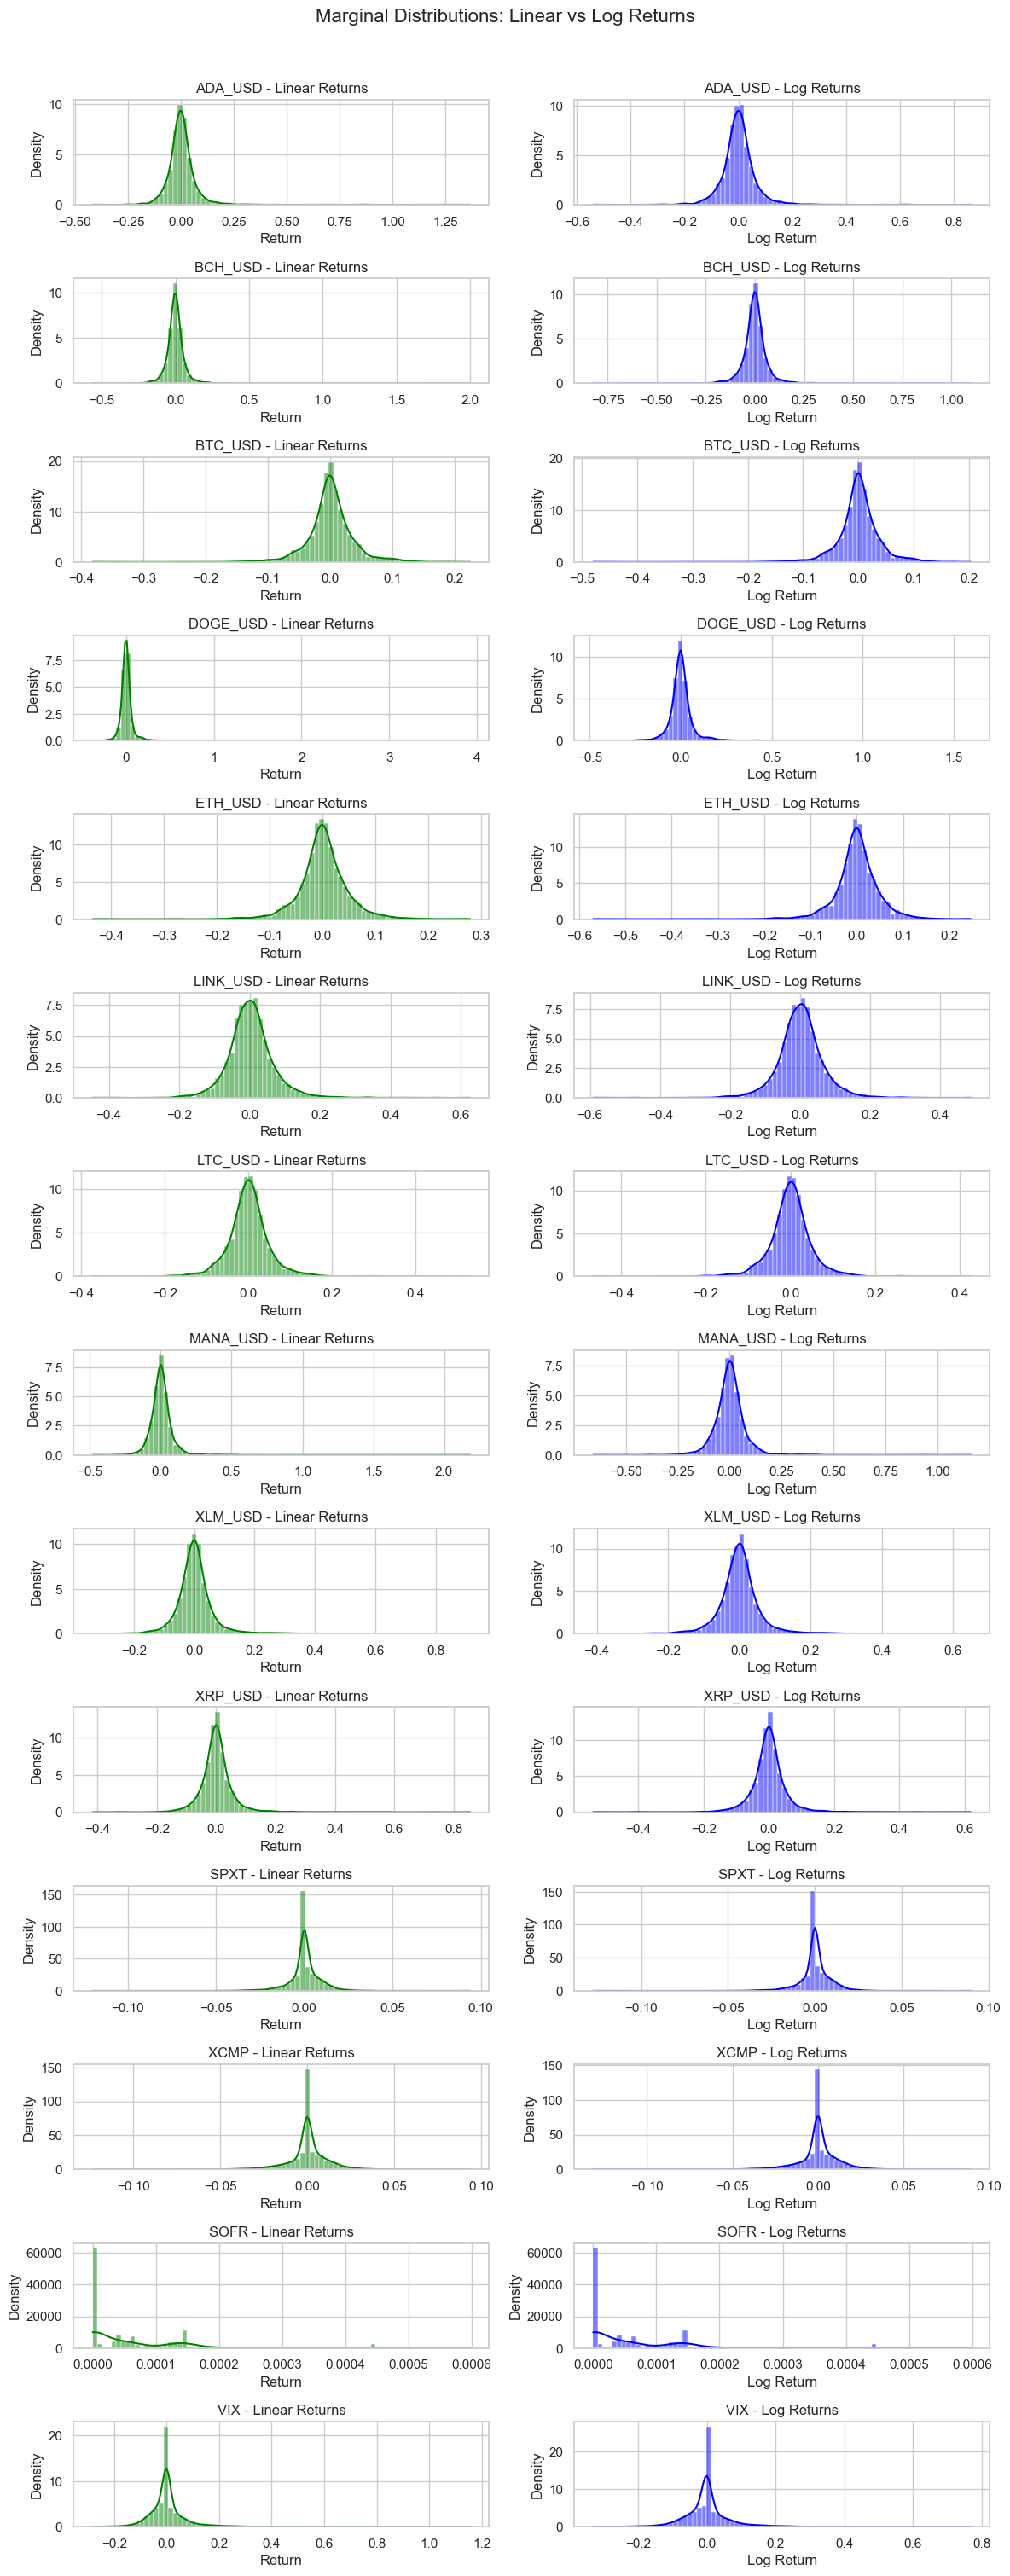

In [6]:
# Set up assets list
assets = linear_returns.columns
n_assets = len(assets)

# Set up subplots: one row per asset, two columns (linear & log)
fig, axes = plt.subplots(n_assets, 2, figsize=(12, n_assets * 2.2))
fig.suptitle("Marginal Distributions: Linear vs Log Returns", fontsize=16)
plt.subplots_adjust(hspace=0.6)

# Plot each asset
for i, asset in enumerate(assets):
    # Linear return plot
    sns.histplot(linear_returns[asset], kde=True, bins=80, ax=axes[i, 0], color='green', stat='density')
    axes[i, 0].set_title(f"{asset} - Linear Returns")
    axes[i, 0].set_xlabel("Return")

    # Log return plot
    sns.histplot(log_returns[asset], kde=True, bins=80, ax=axes[i, 1], color='blue', stat='density')
    axes[i, 1].set_title(f"{asset} - Log Returns")
    axes[i, 1].set_xlabel("Log Return")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Descriptive statistics to choose between linear and log returns

#### For Linear Returns

In [7]:
crypto_assets = assets.values[:-4]

# Compute full descriptive stats for all assets
desc_stats = linear_returns.describe().T
desc_stats["skew"] = linear_returns.skew()
desc_stats["kurtosis"] = linear_returns.kurtosis()
desc_stats = desc_stats[["min", "mean", "max", "50%", "skew", "kurtosis"]].round(4)
desc_stats.rename(columns={"50%": "median"}, inplace=True)

# Compute crypto-only mean skewness and kurtosis
mean_skew_crypto = desc_stats.loc[crypto_assets, "skew"].mean().round(4)
mean_kurtosis_crypto = desc_stats.loc[crypto_assets, "kurtosis"].mean().round(4)
desc_stats

min    mean     max  median     skew  kurtosis
ADA_USD  -0.4166  0.0034  1.3681  0.0000   4.8800   76.2020
BCH_USD  -0.5612  0.0023  2.0003 -0.0003   7.6635  193.9386
BTC_USD  -0.3812  0.0018  0.2255  0.0008  -0.1543    7.4476
DOGE_USD -0.3814  0.0048  3.9230 -0.0005  22.3783  838.7119
ETH_USD  -0.4342  0.0018  0.2790  0.0007  -0.1178    6.2819
LINK_USD -0.4461  0.0034  0.6270  0.0011   0.8453    8.1295
LTC_USD  -0.3726  0.0015  0.5313  0.0006   0.8394   10.8927
MANA_USD -0.4814  0.0045  2.1844  0.0000   7.4611  146.7495
XLM_USD  -0.3364  0.0030  0.9149  0.0002   3.2998   34.4012
XRP_USD  -0.4162  0.0027  0.8558  0.0003   3.0184   32.5788
SPXT     -0.1198  0.0004  0.0939  0.0000  -0.5831   21.2100
XCMP     -0.1232  0.0005  0.0935  0.0000  -0.4731   10.6658
SOFR      0.0000  0.0001  0.0006  0.0000   2.4820    7.0413
VIX      -0.2816  0.0026  1.1560  0.0000   3.5657   37.2509

In [8]:
print("Mean Skewness (Crypto - Linear Returns):", mean_skew_crypto)
print("Mean Kurtosis (Crypto - Linear Returns):", mean_kurtosis_crypto)

Mean Skewness (Crypto - Linear Returns): 5.0114
Mean Kurtosis (Crypto - Linear Returns): 135.5334


#### For Log Returns

In [9]:
# Compute full descriptive stats for all assets
desc_stats = log_returns.describe().T
desc_stats["skew"] = log_returns.skew()
desc_stats["kurtosis"] = log_returns.kurtosis()
desc_stats = desc_stats[["min", "mean", "max", "50%", "skew", "kurtosis"]].round(4)
desc_stats.rename(columns={"50%": "median"}, inplace=True)

# Compute crypto-only mean skewness and kurtosis
mean_skew_crypto = desc_stats.loc[crypto_assets, "skew"].mean().round(4)
mean_kurtosis_crypto = desc_stats.loc[crypto_assets, "kurtosis"].mean().round(4)
desc_stats

min    mean     max  median    skew  kurtosis
ADA_USD  -0.5389  0.0012  0.8621  0.0000  1.7722   24.4679
BCH_USD  -0.8238 -0.0001  1.0987 -0.0003  1.0274   41.6616
BTC_USD  -0.4799  0.0011  0.2034  0.0008 -0.8167   13.1534
DOGE_USD -0.4804  0.0019  1.5939 -0.0005  5.0648  106.2563
ETH_USD  -0.5695  0.0007  0.2461  0.0007 -0.8417   11.2475
LINK_USD -0.5908  0.0013  0.4867  0.0011 -0.0257    7.1948
LTC_USD  -0.4662  0.0002  0.4261  0.0006 -0.0527    9.6341
MANA_USD -0.6565  0.0010  1.1583  0.0000  1.8733   30.5917
XLM_USD  -0.4101  0.0011  0.6497  0.0002  1.5597   16.4606
XRP_USD  -0.5382  0.0009  0.6183  0.0003  1.1648   18.6759
SPXT     -0.1276  0.0003  0.0898  0.0000 -0.9388   22.7896
XCMP     -0.1315  0.0004  0.0894  0.0000 -0.7076   11.6047
SOFR      0.0000  0.0001  0.0006  0.0000  2.4815    7.0386
VIX      -0.3307  0.0003  0.7682  0.0000  1.8388   14.6091

In [10]:
print("Mean Skewness (Crypto - Log Returns):", mean_skew_crypto)
print("Mean Kurtosis (Crypto - Log Returns):", mean_kurtosis_crypto)

Mean Skewness (Crypto - Log Returns): 1.0725
Mean Kurtosis (Crypto - Log Returns): 27.9344


### Zero-return weekends issue

#### In order to deal with the continuous trading of crypto assets (during weekends) we decided to use business-day returns only by removing all the weekend rows. Also, the weekend trading of crypto assets often show abnormal behavior compared to the rest of the week which might cause unwanted results.

In [11]:
linear_returns = linear_returns[linear_returns.index.weekday<5]
log_returns = log_returns[log_returns.index.weekday<5]

## Point b

### Remove Outliers

In [12]:
# Compute the mean and standard deviation for each asset
means = log_returns.mean()
stds  = log_returns.std()

# Build a DataFrame of outlier counts
outlier_counts = pd.DataFrame(index=log_returns.columns)
outlier_counts['Total Obs']      = len(log_returns)
outlier_counts['> 3σ Count']     = ((log_returns - means).abs() > 3 * stds).sum()
outlier_counts['> 4σ Count']     = ((log_returns - means).abs() > 4 * stds).sum()
outlier_counts['> 5σ Count']     = ((log_returns - means).abs() > 5 * stds).sum()

# Reorder for clarity
outlier_counts = outlier_counts[
    ['Total Obs', '> 3σ Count', '> 4σ Count', '> 5σ Count']
]

print(outlier_counts)

          Total Obs  > 3σ Count  > 4σ Count  > 5σ Count
ADA_USD        1949          33          12           4
BCH_USD        1949          36          18           7
BTC_USD        1949          25           8           2
DOGE_USD       1949          25          10           8
ETH_USD        1949          27           7           2
LINK_USD       1949          29           9           4
LTC_USD        1949          24          11           5
MANA_USD       1949          28          14           7
XLM_USD        1949          33          14           9
XRP_USD        1949          33          16          11
SPXT           1949          28          12           8
XCMP           1949          23           8           5
SOFR           1949          82          13           0
VIX            1949          23          13           5


#### Distribution and Kernel densities of crypto assets with and without cleaning outliers

In [13]:
crypto_returns = log_returns[crypto_assets].copy()

##### 1st Analysis: Raw Returns

In [14]:
# Melt the dataframe for seaborn boxplot
melted = crypto_returns.melt(var_name="Asset", value_name="Return")

# Boxplot
fig_box_raw = px.box(melted, x="Asset", y="Return",
                     title="Raw Daily Returns: Boxplot (Crypto Only)",
                     template="plotly_white")

# KDE plot
fig_kde_raw = go.Figure()

for asset in crypto_returns.columns:
    data_temp = crypto_returns[asset].dropna()
    kde = gaussian_kde(data_temp)
    x_range = np.linspace(data_temp.min(), data_temp.max(), 200)
    fig_kde_raw.add_trace(go.Scatter(
        x=x_range,
        y=kde(x_range),
        mode='lines',
        name=asset
    ))

fig_kde_raw.update_layout(
    title="Kernel Densities: Raw Daily Returns (Crypto Only)",
    xaxis_title="Return",
    yaxis_title="Density",
    template="plotly_white"
)

fig_box_raw.show()
fig_kde_raw.show()

#### 2nd Analysis: Winsorized return at 1% threshold

In [15]:
# Compute 1% and 99% cut‑offs for each asset
lower_bounds = crypto_returns.quantile(0.01)
upper_bounds = crypto_returns.quantile(0.99)

# Clip (winsorize) all returns in‑place
crypto_wins = crypto_returns.copy()
for asset in crypto_assets:
    crypto_wins[asset] = crypto_wins[asset].clip(lower_bounds[asset], upper_bounds[asset])

# Melt for seaborn
melted_wins = crypto_wins.melt(var_name="Asset", value_name="Return")

# Boxplot
fig_box = px.box(melted_wins, x="Asset", y="Return", title="Winsorized Daily Returns (1st–99th pctiles): Boxplot")

# KDE plot
fig_kde = go.Figure()
for asset in crypto_returns.columns:
    fig_kde.add_trace(go.Histogram(
        x=crypto_wins[asset],
        histnorm='probability density',
        name=asset,
        opacity=0.6,
        nbinsx=100,
        hovertemplate='%{x:.4f}<br>%{y:.4f}<extra>' + asset + '</extra>',
    ))

# Optional: Smooth it using KDE from scipy
fig_kde = go.Figure()
for asset in crypto_returns.columns:
    x = crypto_wins[asset].dropna()
    kde = gaussian_kde(x)
    x_range = np.linspace(x.min(), x.max(), 200)
    fig_kde.add_trace(go.Scatter(
        x=x_range,
        y=kde(x_range),
        mode='lines',
        name=asset
    ))

fig_kde.update_layout(
    title="Kernel Densities: Winsorized Daily Returns",
    xaxis_title="Return",
    yaxis_title="Density",
    template="plotly_white"
)

# Show plots
fig_box.show()
fig_kde.show()

#### From now, we will use the following cleaned log return dataframe :

In [16]:
# Drop weekend rows (Sat=5, Sun=6)
log_returns_wd = log_returns[log_returns.index.weekday < 5]
linear_returns_wd = linear_returns[linear_returns.index.weekday < 5]

# Compute 1% & 99% percentiles for each column
lower_bounds = log_returns_wd.quantile(0.01)
upper_bounds = log_returns_wd.quantile(0.99)

# Clip (winsorize) all columns
log_returns_cleaned = log_returns_wd.clip(lower=lower_bounds, upper=upper_bounds, axis=1)
linear_returns_cleaned = linear_returns_wd.clip(lower=lower_bounds, upper=upper_bounds, axis=1)

### Correlation analysis

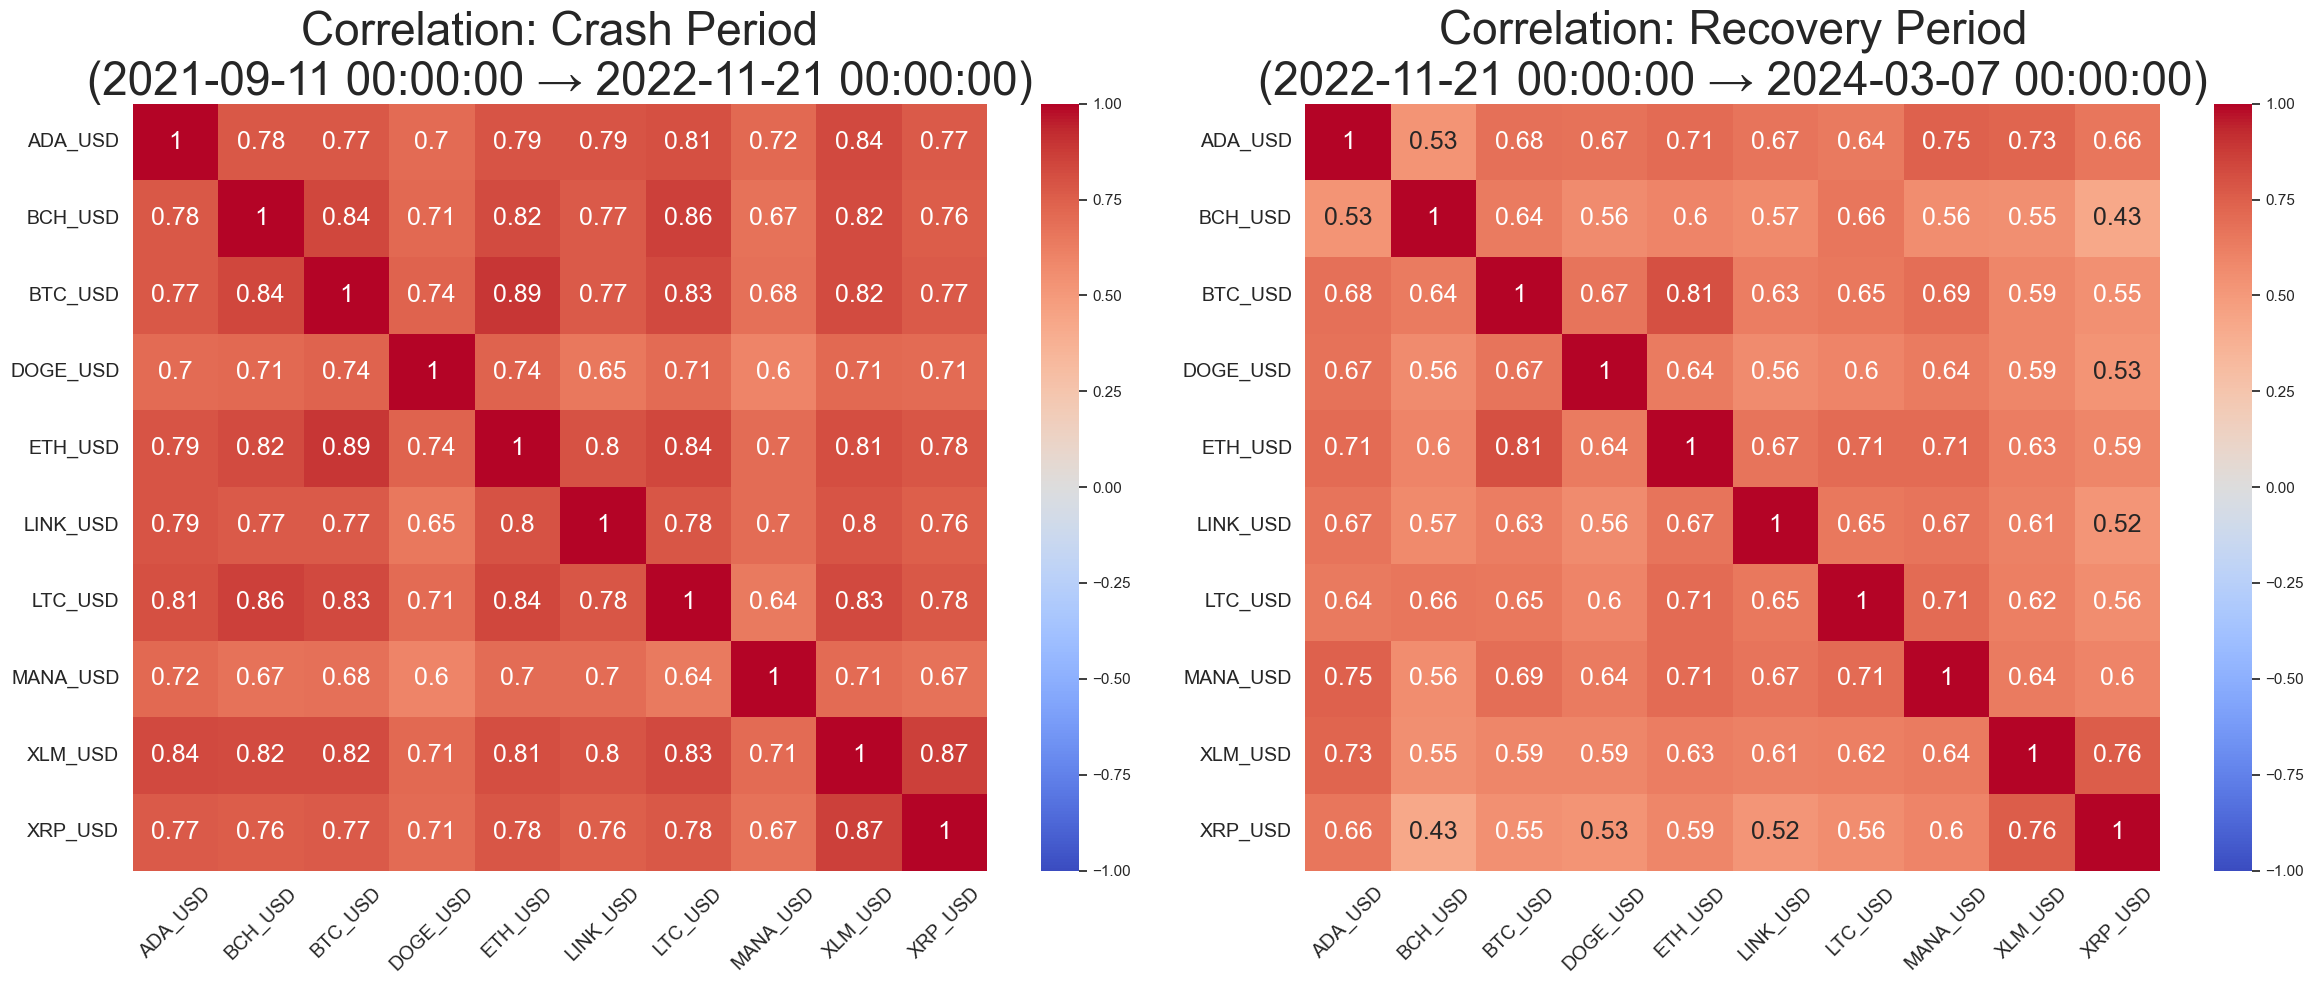

In [17]:
datePP  = pd.to_datetime("2021-09-11")  # Peak before crash
dateTr  = pd.to_datetime("2022-11-21")  # Trough of crash
dateRec = pd.to_datetime("2024-03-07")  # Recovery date

# --- Subset cleaned log returns for each period ---
crash_returns    = log_returns_cleaned.loc[datePP:dateTr][crypto_assets]
recovery_returns = log_returns_cleaned.loc[dateTr:dateRec][crypto_assets]

# --- Plot two heatmaps side by side ---
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

sns.heatmap(
    crash_returns.corr(),
    annot=True,
    cmap="coolwarm",
    center=0,
    ax=axes[0],
    annot_kws={"fontsize": 18},
    vmin=-1, vmax=1
)
axes[0].set_title(f"Correlation: Crash Period\n({datePP} → {dateTr})", fontsize= 33)
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=14, rotation=45)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=14, rotation=0)

sns.heatmap(
    recovery_returns.corr(),
    annot=True,
    cmap="coolwarm",
    center=0,
    ax=axes[1],
    annot_kws={"fontsize": 18},
    vmin=-1, vmax=1
)
axes[1].set_title(f"Correlation: Recovery Period\n({dateTr} → {dateRec})", fontsize= 33)
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=14, rotation=45)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=14, rotation=0)

plt.tight_layout()
plt.show()

### Rolling correlation

In [18]:
reference_asset = "BTC_USD"
crypto_assets_to_plot = [a for a in crypto_assets if a != reference_asset]
rolling_window = 52  # 52 weeks ≃ 1 year

# --- Prepare weekly returns (assuming log_returns_cleaned exists) ---
weekly_log_returns = (
    log_returns_cleaned
    .resample("W-FRI")  # end on Fridays
    .sum()              # additive for log returns
)

# --- Build a DataFrame of rolling correlations ---
rolling_corr_df = pd.DataFrame(index=weekly_log_returns.index)
for asset in crypto_assets_to_plot:
    rolling_corr_df[asset] = (
        weekly_log_returns[reference_asset]
        .rolling(window=rolling_window)
        .corr(weekly_log_returns[asset])
    )

# Compute the cross‑asset average correlation at each date
rolling_corr_df["Average"] = rolling_corr_df.mean(axis=1)

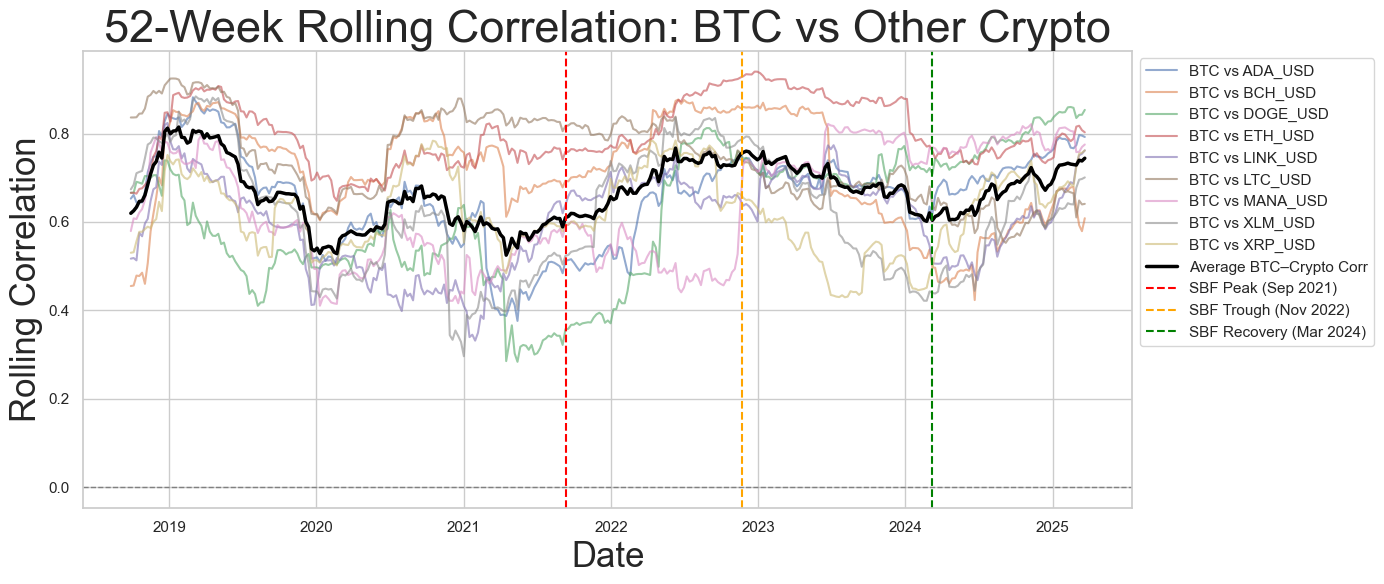

In [19]:

# --- Plot ---
plt.figure(figsize=(14, 6))

# Individual rolling‑corr lines
for asset in crypto_assets_to_plot:
    plt.plot(
        rolling_corr_df.index,
        rolling_corr_df[asset],
        label=f"BTC vs {asset}",
        alpha=0.6
    )

# Average correlation line
plt.plot(
    rolling_corr_df.index,
    rolling_corr_df["Average"],
    label="Average BTC–Crypto Corr",
    color="black",
    linewidth=2.5
)

# Vertical markers for SBF timeline
for dt, label, color in [
    (datePP,  "SBF Peak (Sep 2021)",    "red"),
    (dateTr,  "SBF Trough (Nov 2022)",  "orange"),
    (dateRec, "SBF Recovery (Mar 2024)","green")
]:
    plt.axvline(dt, color=color, linestyle="--", label=label)

plt.title(f"{rolling_window}-Week Rolling Correlation: BTC vs Other Crypto", fontsize=32.5)
plt.xlabel("Date", fontsize=25)
plt.ylabel("Rolling Correlation", fontsize=25)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.grid(True)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Part 2

## Point a

In [20]:
print(f"Distance in days between dateTr and datePP --> {dateTr - datePP}")
print(f"Distance in days between dateRec and dateTr --> {dateRec - dateTr}")


Distance in days between dateTr and datePP --> 436 days 00:00:00
Distance in days between dateRec and dateTr --> 472 days 00:00:00


#### Compute weights and Equally weighted portfolio

In [21]:
weights = np.repeat(1/n_assets, n_assets)

#### Compute returns of Equally Weighted Portfolio

In [22]:
# get new datePP
datePP_friday = datePP - pd.Timedelta(days=1)
datePP_monday = datePP + pd.Timedelta(days=2)

In [23]:
returns_datePP_friday = np.round(weights.T @ log_returns_cleaned.loc[datePP_friday, assets], decimals = 2)
returns_datePP_monday = np.round(weights.T @ log_returns_cleaned.loc[datePP_monday, assets], decimals = 2)
returns_dateTr = np.round(weights.T @ log_returns_cleaned.loc[dateTr, assets], decimals = 2)

print(f"On {datePP_friday}, the equal weighted portfolio has return of {returns_datePP_friday}, ie {returns_datePP_friday * 100}%.")
print(f"On {datePP_monday}, the equal weighted portfolio has return of {returns_datePP_monday}, ie {returns_datePP_monday * 100}%.")
print(f"On {dateTr}, the equal weighted portfolio has return of {returns_dateTr}, ie {returns_dateTr * 100}%.")

On 2021-09-10 00:00:00, the equal weighted portfolio has return of -0.03, ie -3.0%.
On 2021-09-13 00:00:00, the equal weighted portfolio has return of -0.04, ie -4.0%.
On 2022-11-21 00:00:00, the equal weighted portfolio has return of -0.02, ie -2.0%.


## Point b

#### Window Size according to Lopez de Pardo

In [24]:
number_observations = int(n_assets * (n_assets+1) / 2)
print(f"In order to compute the covariance matrix, we need a window size of at least {int(number_observations)} observations.")

adjusted_number_observations = 252# number_observations + 15
print(f"Since {int(number_observations)} corresponds to 3 months and a half, we opted to choose a window size of {int(adjusted_number_observations)}, ie 1 year.")

In order to compute the covariance matrix, we need a window size of at least 105 observations.
Since 105 corresponds to 3 months and a half, we opted to choose a window size of 252, ie 1 year.


#### Create sample pd.DataFrame for both dates

In [25]:
window_size = adjusted_number_observations

data_datePP = log_returns_cleaned.loc[:datePP].tail(window_size)
data_dateTr = log_returns_cleaned.loc[:dateTr].tail(window_size)

## Point c

#### Clip Covariance Matrix: datePP

In [26]:
cov_datePP, clip_cov_datePP = data_datePP.cov(), clip(data_datePP, alpha=None, return_covariance=True)

#### Clip Covariance Matrix: dateTr

In [27]:
cov_dateTr, clip_cov_dateTr = data_dateTr.cov(), clip(data_dateTr, alpha=None, return_covariance=True)

#### Plots

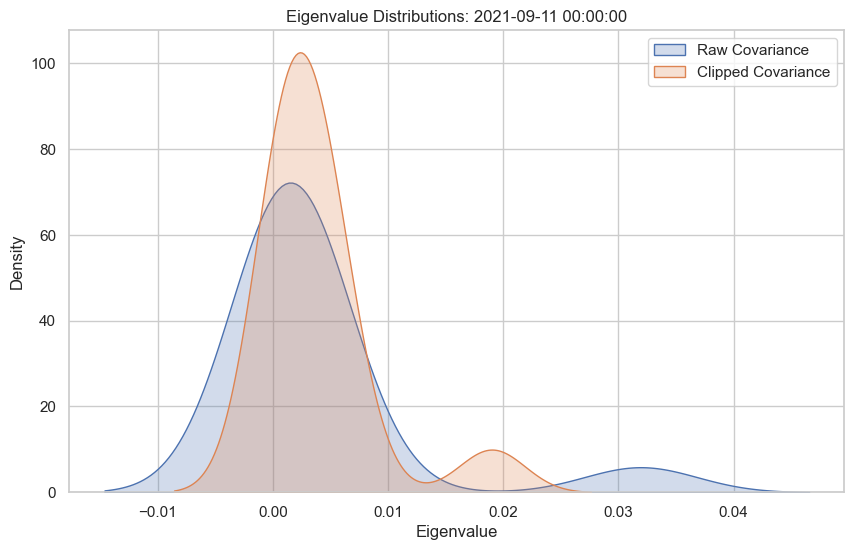

In [28]:
plot_eigenvalue_distribution(cov_datePP, clip_cov_datePP, f"{datePP}")


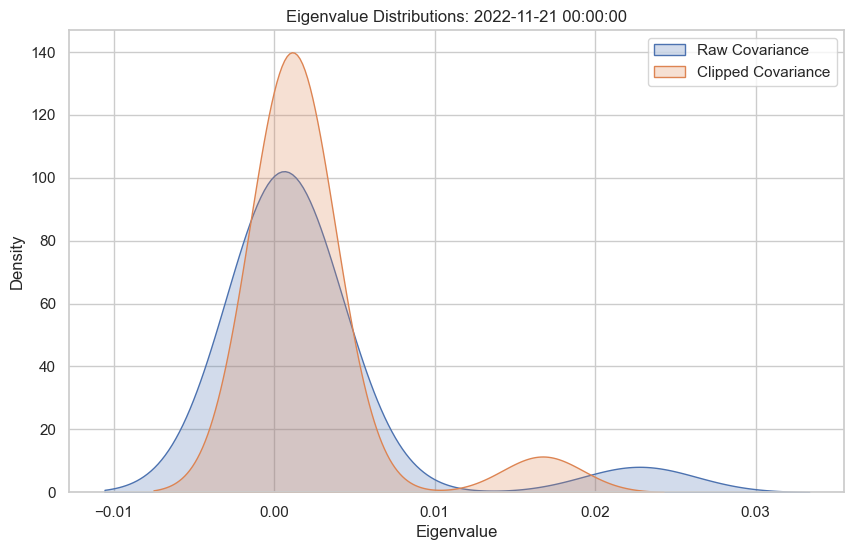

In [29]:
plot_eigenvalue_distribution(cov_dateTr, clip_cov_dateTr, f"{dateTr}")

In [30]:
plot_3d_cov_matrix(cov_datePP, f"Raw Covariance Matrix ({datePP})")

In [31]:
plot_3d_cov_matrix(pd.DataFrame(clip_cov_datePP), f"Clipped Covariance Matrix ({datePP})")

In [32]:
plot_3d_cov_matrix(cov_dateTr, f"Raw Covariance Matrix ({dateTr})")

In [33]:
plot_3d_cov_matrix(pd.DataFrame(clip_cov_dateTr), f"Clipped Covariance Matrix ({dateTr})")

#### Compute the Condition Number

In [34]:
cond_number_datePP = compute_condition_number(clip_cov_datePP)
cond_number_datePP_clipped = compute_condition_number(cov_datePP)

cond_number_dateTr = compute_condition_number(clip_cov_dateTr)
cond_number_dateTr_clipped = compute_condition_number(cov_dateTr)
    
print(f"Condition number on {datePP} for Covariance matrix ix {cond_number_datePP}")
print(f"Condition number on {datePP} for Clipped Covariance matrix ix {cond_number_datePP_clipped}")
print(f"Condition number on {dateTr} for Covariance matrix ix {cond_number_dateTr}")
print(f"Condition number on {dateTr} for Clipped Covariance matrix ix {cond_number_dateTr_clipped}")


Condition number on 2021-09-11 00:00:00 for Covariance matrix ix 22448334753.268234
Condition number on 2021-09-11 00:00:00 for Clipped Covariance matrix ix 9552027258.859314
Condition number on 2022-11-21 00:00:00 for Covariance matrix ix 27296650.45966189
Condition number on 2022-11-21 00:00:00 for Clipped Covariance matrix ix 5430837.515189625


In [35]:
print("The ratios are:")
print(f"----> {cond_number_datePP_clipped / cond_number_datePP} on {datePP} after clipping the covariance matrix.")
print(f"----> {cond_number_dateTr_clipped / cond_number_dateTr} on {dateTr} after clipping the covariance matrix.")

The ratios are:
----> 0.42551161873905335 on 2021-09-11 00:00:00 after clipping the covariance matrix.
----> 0.19895618780095903 on 2022-11-21 00:00:00 after clipping the covariance matrix.


### Point d

#### Euler Risk Contribution: datePP and NON Clipped Cov Matrix

In [36]:
rc_datePP = compute_Euler_risk_contribution(weights, cov_datePP, percentage=False)
rc_datePP_percentage = compute_Euler_risk_contribution(weights, cov_datePP, percentage=True)

In [37]:
plot_Euler_risk_contribution(rc_datePP_percentage, title=f"Euler Risk Contributions on {datePP} using Covariance Matrix")

#### Euler Risk Contribution: datePP and Clipped Cov Matrix

In [38]:
rc_datePP_clipped = compute_Euler_risk_contribution(weights, pd.DataFrame(clip_cov_datePP), percentage=False)
rc_datePP_clipped_percentage = compute_Euler_risk_contribution(weights, clip_cov_datePP, percentage=True)

In [39]:
plot_Euler_risk_contribution(rc_datePP_clipped_percentage, title=f"Euler Risk Contributions on {datePP} using Clipped Covariance Matrix")

#### Euler Risk Contribution: dateTr and NOT Clipped Cov Matrix

In [40]:
rc_dateTr = compute_Euler_risk_contribution(weights, cov_dateTr, percentage=False)
rc_dateTr_percentage = compute_Euler_risk_contribution(weights, cov_dateTr, percentage=True)

In [41]:
plot_Euler_risk_contribution(rc_dateTr_percentage, title=f"Euler Risk Contributions on {dateTr} using Covariance Matrix")

#### Euler Risk Contribution: dateTr and Clipped Cov Matrix

In [42]:
np.repeat(1/14, 14)

array([0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857])

In [43]:
rc_dateTr_clipped = compute_Euler_risk_contribution(weights, clip_cov_dateTr, percentage=False)
rc_dateTr_clipped_percentage = compute_Euler_risk_contribution(weights, clip_cov_dateTr, percentage=True)

In [44]:
plot_Euler_risk_contribution(rc_dateTr_clipped_percentage, title=f"Euler Risk Contributions on {dateTr} using Clipped Covariance Matrix")

### Compute the Herfindahl Hirshmann index for every case

In [45]:
hhi_datePP = compute_Herfindahl_Hirshmann_index(rc_datePP_percentage)
print(f"On date {datePP}, the Herfindahl Hirshmann index is {np.round(hhi_datePP, decimals=6) * 100}%")

On date 2021-09-11 00:00:00, the Herfindahl Hirshmann index is 10.7054%


In [46]:
hhi_datePP_clip = compute_Herfindahl_Hirshmann_index(rc_datePP_clipped_percentage)
print(f"On date {datePP}, the Herfindahl Hirshmann index is {np.round(hhi_datePP_clip, decimals=6) * 100}%")

On date 2021-09-11 00:00:00, the Herfindahl Hirshmann index is 12.8779%


In [47]:
hhi_dateTr = compute_Herfindahl_Hirshmann_index(rc_dateTr_percentage)
print(f"On date {datePP}, the Herfindahl Hirshmann index is {np.round(hhi_dateTr, decimals=6) * 100}%")

On date 2021-09-11 00:00:00, the Herfindahl Hirshmann index is 11.077399999999999%


In [48]:
hhi_dateTr_clip = compute_Herfindahl_Hirshmann_index(rc_dateTr_clipped_percentage)
print(f"On date {datePP}, the Herfindahl Hirshmann index is {np.round(hhi_dateTr_clip, decimals=6) * 100}%")

On date 2021-09-11 00:00:00, the Herfindahl Hirshmann index is 28.7854%


## Point e

#### Create diversification distribution of the portfolios: datePP

In [85]:
enb_raw_datePP, distr_raw_datePP = calculate_effective_number_of_bets(weights, cov_datePP)
enb_clipped_datePP, distr_clipped_datePP = calculate_effective_number_of_bets(weights, clip_cov_datePP)

print(f"ENB (raw covariance) on {datePP.to_period(freq="D")}: {enb_raw_datePP:.3f}")
print(f"ENB (clipped covariance) on {datePP.to_period(freq="D")}: {enb_clipped_datePP:.3f}")


ENB (raw covariance) on 2021-09-11: 1.341
ENB (clipped covariance) on 2021-09-11: 4.369


In [50]:
def plot_diversification_distribution(div_dist, labels=None, title="Diversification Distribution"):
    """
    Plot the diversification distribution as an interactive bar chart using Plotly.
    
    Parameters:
    -----------
    div_dist : array-like
        The diversification distribution values to plot
    labels : array-like, optional
        Custom labels for the x-axis. If provided, must have the same length as div_dist
    title : str, default "Diversification Distribution"
        Title for the plot
    
    Returns:
    --------
    plotly.graph_objects.Figure
        The interactive Plotly figure
    """
    # Default x-values as integers if no labels provided
    if labels is None:
        x = np.arange(1, len(div_dist) + 1)
    else:
        # Validate that labels match the length of div_dist
        if len(labels) != len(div_dist):
            raise ValueError(f"Length of labels ({len(labels)}) must match length of div_dist ({len(div_dist)})")
        x = labels
    
    fig = go.Figure(data=[
        go.Bar(x=x, y=div_dist, marker=dict(color='steelblue'))
    ])
    
    fig.update_layout(
        title=title,
        xaxis_title='Principal Portfolios' if labels is None else 'Assets',
        yaxis_title='Contribution to Portfolio Risk',
        template='plotly_white',
        xaxis=dict(tickmode='linear' if labels is None else 'array', tickvals=x),
        yaxis=dict(gridcolor='lightgray'),
        bargap=0.2
    )
    
    return fig

In [51]:
plot_diversification_distribution(distr_raw_datePP, title=f'Diversification Distribution on {datePP.to_period(freq="D")} for Raw Cov Matrix')

In [52]:
plot_diversification_distribution(distr_clipped_datePP , title=f'Diversification Distribution on {datePP.to_period(freq="D")} for Clipped Cov Matrix')

#### Create diversification distribution of the portfolios: dateTr

In [53]:
enb_raw_dateTr, distr_raw_dateTr = calculate_effective_number_of_bets(weights, cov_dateTr)
enb_clipped_dateTr, distr_clipped_dateTr = calculate_effective_number_of_bets(weights, clip_cov_dateTr)

print(f"ENB (raw covariance) on {dateTr.to_period(freq="D")}: {enb_raw_dateTr:.3f}")
print(f"ENB (clipped covariance) on {dateTr.to_period(freq="D")}: {enb_clipped_dateTr:.3f}")


ENB (raw covariance) on 2022-11-21: 1.214
ENB (clipped covariance) on 2022-11-21: 6.499


In [54]:
plot_diversification_distribution(distr_raw_dateTr , title=f'Diversification Distribution on {dateTr.to_period(freq="D")} for Raw Cov Matrix')

In [55]:
plot_diversification_distribution(distr_clipped_dateTr, title=f'Diversification Distribution on {dateTr.to_period(freq="D")} for Clipped Cov Matrix')

### Compute Weights for maximum diversification Portfolio

In [56]:
def maximize_diversification(cov_matrix: pd.DataFrame, long_only: bool=True, max_weight=None):
    """
    Compute the maximally diversified portfolio by maximizing the Effective Number of Bets.
    
    Parameters:
    -----------
    cov_matrix : numpy.ndarray or pandas.DataFrame
        Covariance matrix of asset returns
    long_only : bool, optional
        Whether to enforce long-only constraints, default is True
    max_weight : float, optional
        Maximum weight for any single asset (for concentration limits), default is None
        
    Returns:
    --------
    dict
        Dictionary containing optimal weights, ENB, and diversification distribution
    """
    n_assets = len(cov_matrix)
    
    # Convert to numpy array if pandas DataFrame
    if isinstance(cov_matrix, pd.DataFrame):
        asset_names = cov_matrix.index
        cov_matrix = cov_matrix.values
    else:
        asset_names = [f'Asset_{i+1}' for i in range(n_assets)]
    
    # Define objective function (negative ENB to minimize)
    def neg_enb(weights):
        enb, _ = calculate_effective_number_of_bets(weights, cov_matrix)
        return -enb  # Negative because we want to maximize ENB
    
    # Constraints: weights sum to 1
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    
    # Bounds
    if long_only:
        if max_weight is not None:
            bounds = tuple((0, max_weight) for _ in range(n_assets))
        else:
            bounds = tuple((0, 1) for _ in range(n_assets))
    else:
        if max_weight is not None:
            bounds = tuple((-max_weight, max_weight) for _ in range(n_assets))
        else:
            bounds = tuple((None, None) for _ in range(n_assets))
    
    # Initial guess: equal weights
    initial_weights = np.ones(n_assets) / n_assets
    
    # Minimize negative ENB, ie maximize ENB
    result = minimize(
        neg_enb, 
        initial_weights, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints,
        options={'ftol': 1e-9, 'maxiter': 1000}
    )
    
    # Get optimal weights
    optimal_weights = result['x']
    
    # Calculate final ENB and diversification distribution
    final_enb, div_dist = calculate_effective_number_of_bets(optimal_weights, cov_matrix)
    
    # Package results
    results = {
        'weights': pd.Series(optimal_weights, index=asset_names),
        'enb': final_enb,
        'diversification_ratio': final_enb / n_assets,
        'diversification_distribution': pd.Series(
            div_dist, 
            index=[f'PC{i+1}' for i in range(n_assets)]
        )
    }
    
    return results

In [57]:
max_divers_weights_datePP = maximize_diversification(clip_cov_datePP)['weights']
print(f"Max Diversification Weights on {datePP}:")
display(max_divers_weights_datePP.sort_values(ascending=False))

max_divers_weights_dateTr = maximize_diversification(clip_cov_dateTr)['weights']
print(f"Max Diversification Weights on {dateTr}:")
display(max_divers_weights_dateTr.sort_values(ascending=False))


Max Diversification Weights on 2021-09-11 00:00:00:


SPXT        5.552661e-01
ETH_USD     1.197890e-01
BTC_USD     7.130864e-02
XCMP        7.077885e-02
DOGE_USD    5.330574e-02
BCH_USD     4.703546e-02
XRP_USD     4.344823e-02
MANA_USD    3.906800e-02
XLM_USD     5.968703e-13
LTC_USD     7.734104e-14
LINK_USD    3.041374e-14
ADA_USD     0.000000e+00
SOFR        0.000000e+00
VIX         0.000000e+00
dtype: float64

Max Diversification Weights on 2022-11-21 00:00:00:


SPXT        2.026646e-01
XRP_USD     1.493439e-01
XCMP        1.268008e-01
XLM_USD     1.077434e-01
ETH_USD     7.941981e-02
BTC_USD     7.660319e-02
DOGE_USD    7.511241e-02
BCH_USD     5.857621e-02
VIX         5.430262e-02
ADA_USD     3.806143e-02
MANA_USD    3.137155e-02
SOFR        2.870380e-12
LINK_USD    3.416351e-14
LTC_USD     0.000000e+00
dtype: float64

## Point f

In [58]:
def calculate_total_losses(df: pd.DataFrame, start_date: str, end_date: str) -> pd.Series:
    # Ensure index is datetime
    data = df.copy()
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    # Slice period
    period = data.loc[start_date:end_date]
    if period.empty:
        raise ValueError(f"No data found between {start_date} and {end_date}.")

    # Sum log returns
    total_log_returns = period.sum(axis=0)

    # Losses as positive values for assets with negative returns
    losses = -total_log_returns

    # Sort ascending by cumulative return -> descending by loss
    losses_sorted = losses.sort_values(ascending=False)
    return losses_sorted

def plot_loss_ranking(losses: pd.Series, title: str = None, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    losses.plot(kind='bar', ax=ax)
    ax.set_ylabel('Loss (negative total log return)')
    ax.set_xlabel('Asset')
    if title:
        ax.set_title(title)
    plt.tight_layout()
    return fig, ax

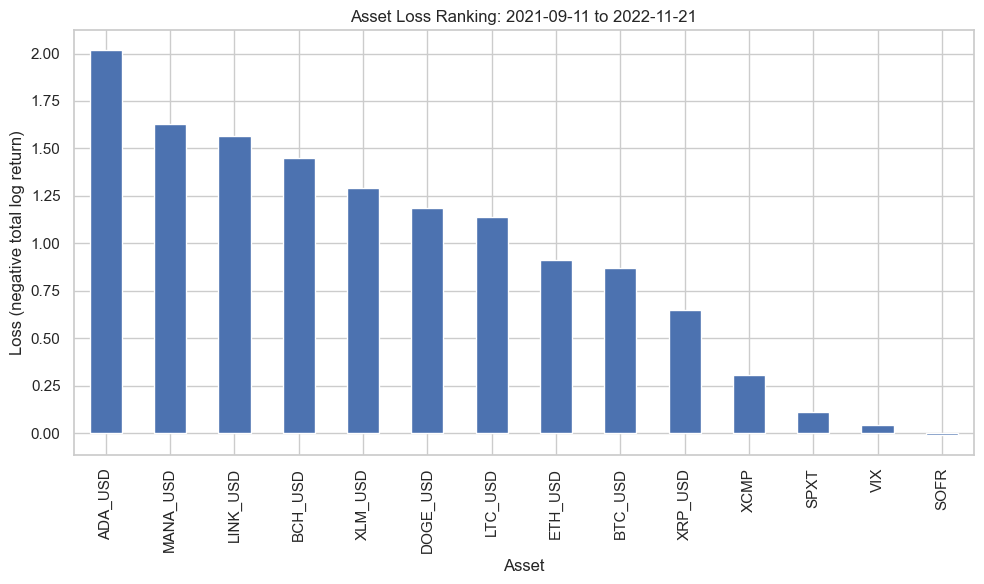

In [59]:
# compute losses between your peak/trough
losses = calculate_total_losses(log_returns_cleaned, datePP, dateTr)

#%%
# plot
fig, ax = plot_loss_ranking(
    losses,
    title=f'Asset Loss Ranking: {datePP.to_period(freq="D")} to {dateTr.to_period(freq="D")}'
)
plt.show()

### Merge Risk and Loss

In [60]:
def merge_risk_loss(risk: pd.DataFrame, loss: pd.DataFrame) :
    risk_df = risk.rename('Risk').reset_index().rename(columns={'index': 'Asset'})
    merged_df = pd.DataFrame({'Asset': loss.index, 'Loss': loss.values})
    merged = pd.merge(merged_df, risk_df, on='Asset')
    return merged


merged = merge_risk_loss(rc_dateTr_clipped_percentage, losses)

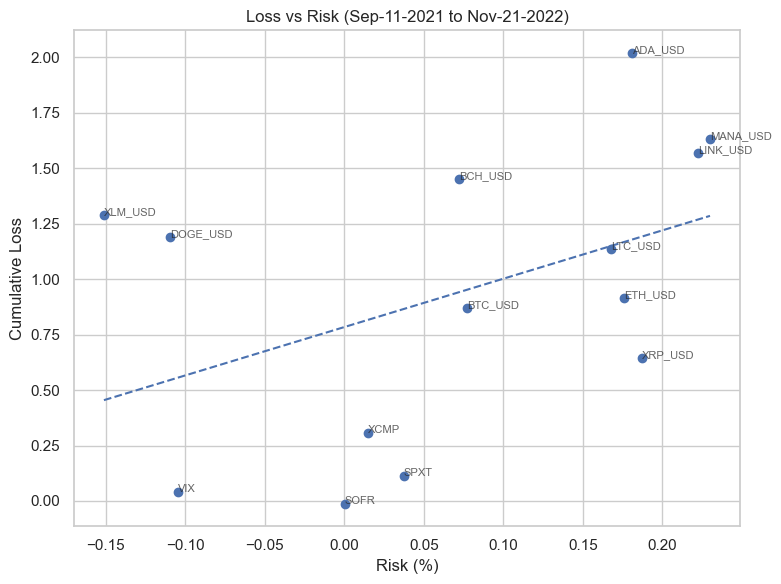

In [61]:
def plot_loss_vs_risk(merged_df: pd.DataFrame, title=None, figsize=(8,6)):
    x = merged_df['Risk']
    y = merged_df['Loss']
    # fit a simple linear trend
    m, b = np.polyfit(x, y, 1)

    plt.figure(figsize=figsize)
    plt.scatter(x, y)
    # regression line
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, m*xs + b, linestyle='--')
    for _, row in merged_df.iterrows():
        plt.text(row['Risk'], row['Loss'], row['Asset'], fontsize=8, alpha=0.7)

    plt.xlabel('Risk (%)')
    plt.ylabel('Cumulative Loss')
    if title:
        plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_vs_risk(merged, title="Loss vs Risk (Sep-11-2021 to Nov-21-2022)")

In [62]:
def plot_rank_vs_rank(merged_df: pd.DataFrame, title="Rank of Risk vs Rank of Loss", figsize=(8, 6)):
    df = merged_df.copy()
    
    # 1 = least risky/least loss
    df['Risk Rank'] = df['Risk'].rank(method='min', ascending=True).astype(int)
    df['Loss Rank'] = df['Loss'].rank(method='min', ascending=True).astype(int)
    max_rank = max(df['Risk Rank'].max(), df['Loss Rank'].max())

    plt.figure(figsize=figsize)
    sns.scatterplot(data=df, x='Risk Rank', y='Loss Rank', hue='Asset', s=100)
    plt.plot([1, max_rank], [1, max_rank], linestyle='--', color='gray', label='Perfect alignment')

    # Annotate each point
    for _, row in df.iterrows():
        plt.text(row['Risk Rank'] + 0.2, row['Loss Rank'], row['Asset'], fontsize=9, alpha=0.7)

    plt.xlabel('Risk Rank (1 = least risky)')
    plt.ylabel('Loss Rank (1 = least loss)')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


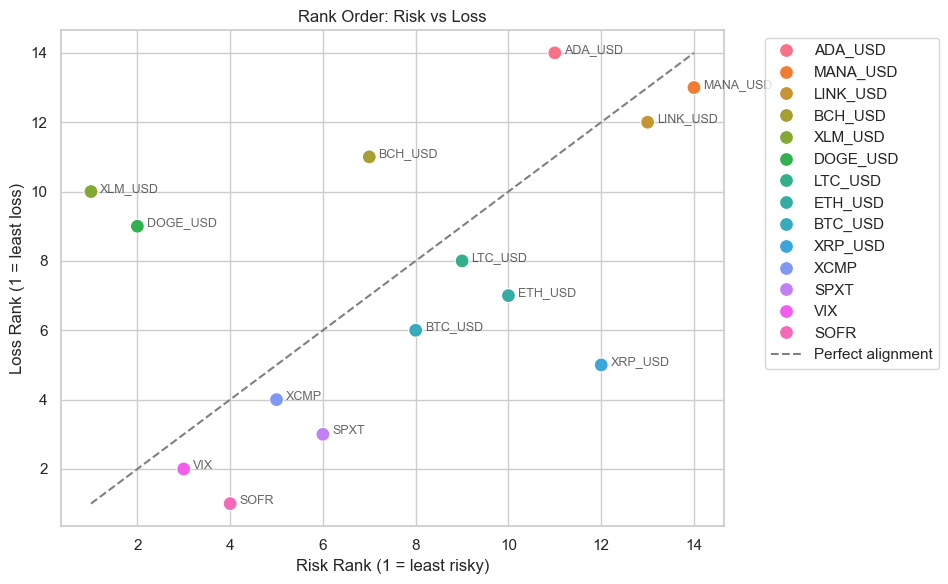

In [63]:
plot_rank_vs_rank(merged, title="Rank Order: Risk vs Loss")

In [64]:
print(kendalltau(merged['Risk'], merged['Loss']))

SignificanceResult(statistic=np.float64(0.3406593406593407), pvalue=np.float64(0.10102087460966429))


# Part 3.a

## i. The minimum variance portfolio (MVP)

In [65]:
# MVP at previous peak (datePP)
mvp_weights_PP = compute_mvp(clip_cov_datePP)
print("MVP Weights at datePP:")
display(mvp_weights_PP.sort_values(ascending=False))


# MVP at trough (dateTr)
mvp_weights_Tr = compute_mvp(clip_cov_dateTr)
print("MVP Weights at dateTr:")
display(mvp_weights_Tr.sort_values(ascending=False))

MVP Weights at datePP:


SOFR        0.999963
SPXT        0.000024
DOGE_USD    0.000009
BTC_USD     0.000004
BCH_USD     0.000000
ADA_USD     0.000000
LINK_USD    0.000000
ETH_USD     0.000000
LTC_USD     0.000000
MANA_USD    0.000000
XRP_USD     0.000000
XLM_USD     0.000000
XCMP        0.000000
VIX         0.000000
dtype: float64

MVP Weights at dateTr:


SOFR        0.998680
XLM_USD     0.000965
DOGE_USD    0.000190
VIX         0.000135
BCH_USD     0.000029
ADA_USD     0.000000
LINK_USD    0.000000
ETH_USD     0.000000
BTC_USD     0.000000
LTC_USD     0.000000
XRP_USD     0.000000
MANA_USD    0.000000
XCMP        0.000000
SPXT        0.000000
dtype: float64

## ii. The equal risk contribution portfolio (see Roncalli, 2009) (ERC)

In [66]:
# ERC at datePP
erc_weights_PP = compute_erc(clip_cov_datePP)
print("ERC Weights at datePP:")
display(erc_weights_PP.sort_values(ascending=False))


# ERC at dateTr
erc_weights_Tr = compute_erc(clip_cov_dateTr)
print("ERC Weights at dateTr:")
display(erc_weights_Tr.sort_values(ascending=False))

ERC Weights at datePP:


SOFR        0.998574
SPXT        0.000595
XCMP        0.000266
BTC_USD     0.000114
DOGE_USD    0.000096
XRP_USD     0.000054
ETH_USD     0.000051
XLM_USD     0.000043
MANA_USD    0.000039
BCH_USD     0.000037
ADA_USD     0.000035
VIX         0.000034
LTC_USD     0.000033
LINK_USD    0.000028
dtype: float64

ERC Weights at dateTr:


SOFR        0.981503
XLM_USD     0.003948
SPXT        0.002840
XCMP        0.002001
DOGE_USD    0.001353
XRP_USD     0.001272
MANA_USD    0.001054
VIX         0.001027
BTC_USD     0.001016
LTC_USD     0.000865
ETH_USD     0.000835
BCH_USD     0.000812
LINK_USD    0.000792
ADA_USD     0.000683
dtype: float64

### iii. The minimum effective number of bets portfolio of Meucci (2009) (Meucci_ENB)

In [67]:
# Meucci_ENB at datePP
meucci_weights_PP = compute_meucci_min_enb_portfolio(clip_cov_datePP)
print("Meucci Weights at datePP:")
display(meucci_weights_PP.round(5).sort_values(ascending=False))


# Meucci_ENB at dateTr
meucci_weights_Tr = compute_meucci_min_enb_portfolio(clip_cov_dateTr)
print("Meucci Weights at dateTr:")
display(meucci_weights_Tr.round(5).sort_values(ascending=False))

Meucci Weights at datePP:


ETH_USD     0.16955
SPXT        0.11642
BCH_USD     0.09870
MANA_USD    0.09582
SOFR        0.08923
DOGE_USD    0.08830
LTC_USD     0.08781
XRP_USD     0.08427
BTC_USD     0.07622
ADA_USD     0.04827
XCMP        0.04540
LINK_USD    0.00000
XLM_USD     0.00000
VIX         0.00000
dtype: float64

Meucci Weights at dateTr:


XRP_USD     0.13595
ETH_USD     0.12658
BTC_USD     0.09727
BCH_USD     0.08915
SPXT        0.08762
XCMP        0.08093
SOFR        0.08044
ADA_USD     0.07750
MANA_USD    0.06421
DOGE_USD    0.05917
VIX         0.05081
LINK_USD    0.03028
XLM_USD     0.02010
LTC_USD     0.00000
dtype: float64

### iv. The hierarchical risk parity portfolio of Lopez De Prado (2016) (HRP)

In [68]:
# HRP at datePP
hrp_weights_PP = compute_hrp(clip_cov_datePP)
print("HRP Weights at datePP:")
display(hrp_weights_PP.round(5).sort_values(ascending=False))

# HRP at dateTr
hrp_weights_Tr = compute_hrp(clip_cov_dateTr)
print("HRP Weights at dateTr:")
display(hrp_weights_Tr.round(5).sort_values(ascending=False))

HRP Weights at datePP:


BTC_USD     0.42957
XCMP        0.17069
SPXT        0.11350
VIX         0.08231
SOFR        0.05888
XRP_USD     0.03960
MANA_USD    0.03266
ETH_USD     0.02616
ADA_USD     0.01581
LTC_USD     0.01348
BCH_USD     0.01183
XLM_USD     0.00431
DOGE_USD    0.00120
LINK_USD    0.00000
dtype: float64

HRP Weights at dateTr:


XCMP        0.21533
BTC_USD     0.16308
LTC_USD     0.12578
BCH_USD     0.12454
SOFR        0.11703
XLM_USD     0.10511
SPXT        0.05789
ADA_USD     0.02606
ETH_USD     0.02077
DOGE_USD    0.01583
LINK_USD    0.01509
VIX         0.01025
MANA_USD    0.00325
XRP_USD     0.00000
dtype: float64

# Part 3.b

In [69]:
#1. 1. Combine All Weights into One DataFrame

# Combine into one DataFrame
portfolios = pd.DataFrame({
    'EW_PP': weights,
    'MVP_PP': mvp_weights_PP,
    'ERC_PP': erc_weights_PP,
    'ENB_PP': meucci_weights_PP,
    'HRP_PP': hrp_weights_PP,
    'MAX_DIV_PP': max_divers_weights_datePP,
    'EW_Tr': weights,
    'MVP_Tr': mvp_weights_Tr,
    'ERC_Tr': erc_weights_Tr,
    'ENB_Tr': meucci_weights_Tr,
    'HRP_Tr': hrp_weights_Tr,
    'MAX_DIV_Tr': max_divers_weights_dateTr,
}).fillna(0)

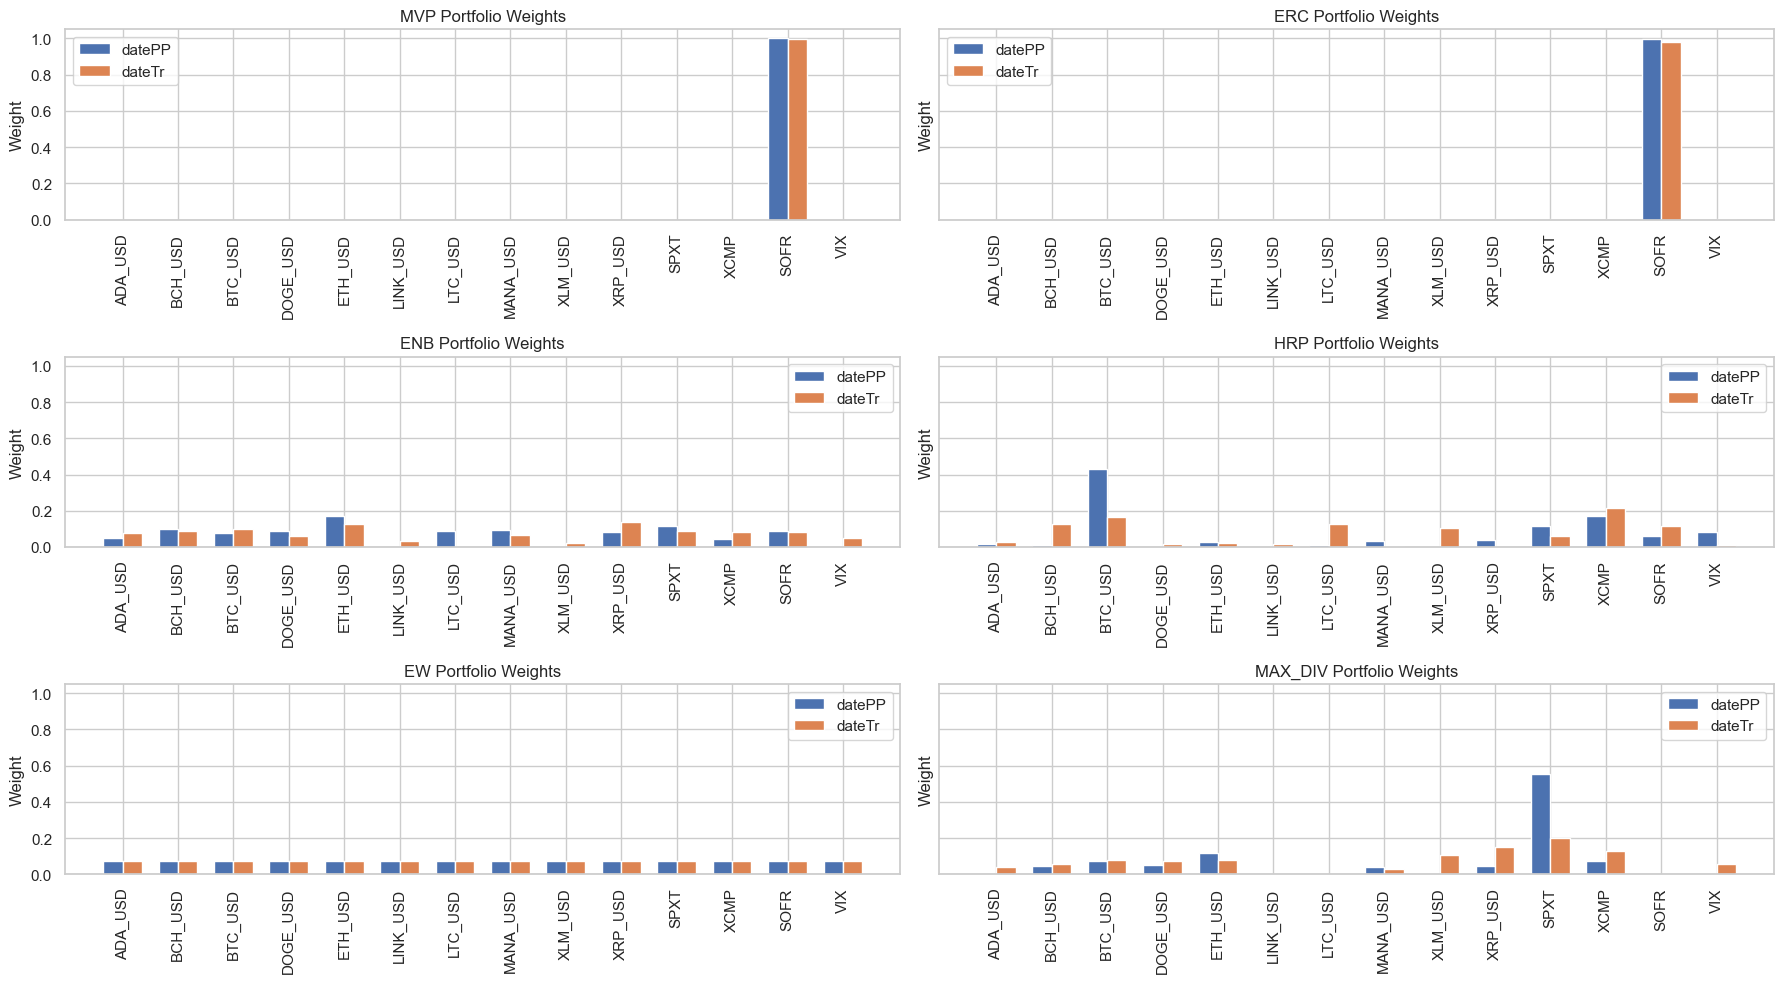

In [70]:
# Plot Comparison (Group by Portfolio Type)

portfolio_types = ['MVP', 'ERC', 'ENB', 'HRP', 'EW', 'MAX_DIV']
bar_width = 0.35
x = np.arange(len(portfolios.index))  # One bar group per asset

fig, axes = plt.subplots(3, 2, figsize=(18, 10), sharey=True)
axes = axes.flatten()

for i, pt in enumerate(portfolio_types):
    ax = axes[i]
    weights_PP = portfolios[f'{pt}_PP']
    weights_Tr = portfolios[f'{pt}_Tr']

    ax.bar(x - bar_width/2, weights_PP, width=bar_width, label='datePP')
    ax.bar(x + bar_width/2, weights_Tr, width=bar_width, label='dateTr')

    ax.set_title(f'{pt} Portfolio Weights')
    ax.set_xticks(x)
    ax.set_xticklabels(portfolios.index, rotation=90)
    ax.set_ylabel('Weight')
    ax.grid(True)
    ax.legend()

# Hide any unused subplot (e.g., 6th slot when we have only 5 portfolios)
    #if len(portfolio_types) < len(axes):
       # for j in range(len(portfolio_types), len(axes)):
        #    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [71]:
# Convert to long-format DataFrame
portfolios_long = portfolios.reset_index().melt(id_vars='index', var_name='Portfolio', value_name='Weight')
portfolios_long = portfolios_long.rename(columns={'index': 'Asset'})

# Split 'Portfolio' column into 'Method' and 'Date'
portfolios_long['Method'] = portfolios_long['Portfolio'].str.extract(r'^(.*)_')[0]
portfolios_long['Date'] = portfolios_long['Portfolio'].str.extract(r'_(PP|Tr)$')[0]

# Optional: Clean up column order
portfolios_long = portfolios_long[['Method', 'Date', 'Asset', 'Weight']]

# Create a new label for x-axis
portfolios_long['Method_Date'] = portfolios_long['Method'] + "_" + portfolios_long['Date']

In [72]:
# Comparing Portfolios among Methods and Dates

fig = px.bar(
    portfolios_long,
    x="Method_Date",
    y="Weight",
    color="Asset",
    title="Portfolio Weights Across Methods and Dates",
    labels={"Weight": "Weight Allocation"},
    text_auto=".2f"
)
fig.update_layout(barmode="stack", xaxis_tickangle=-45)
fig.show()

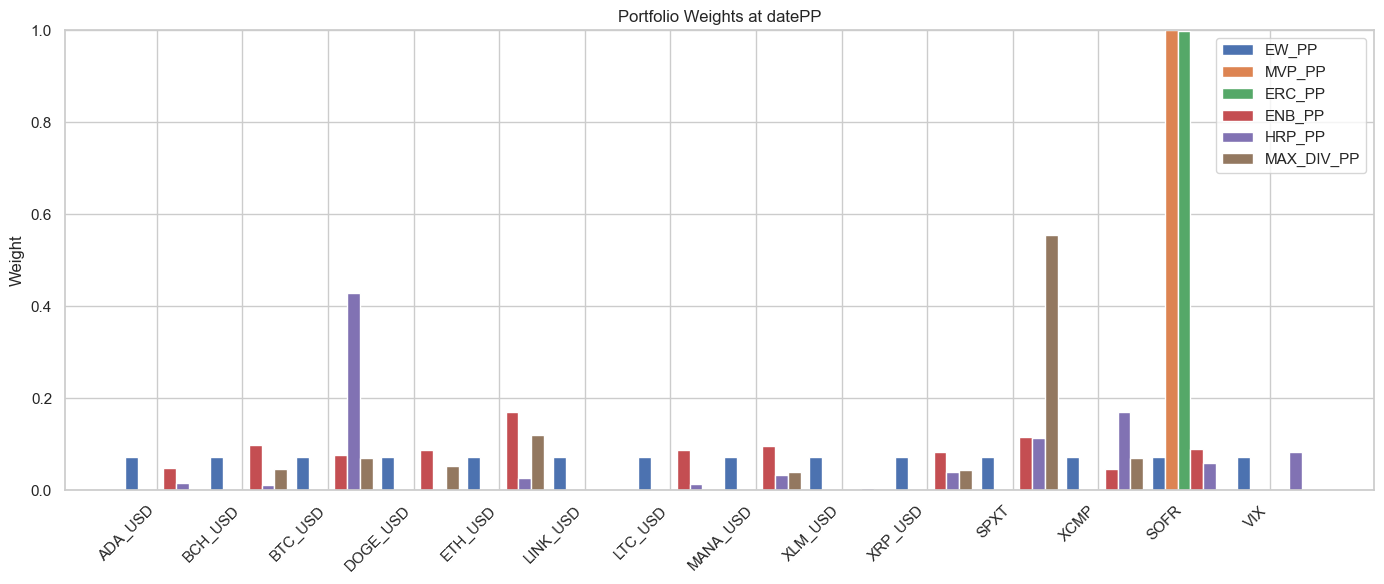

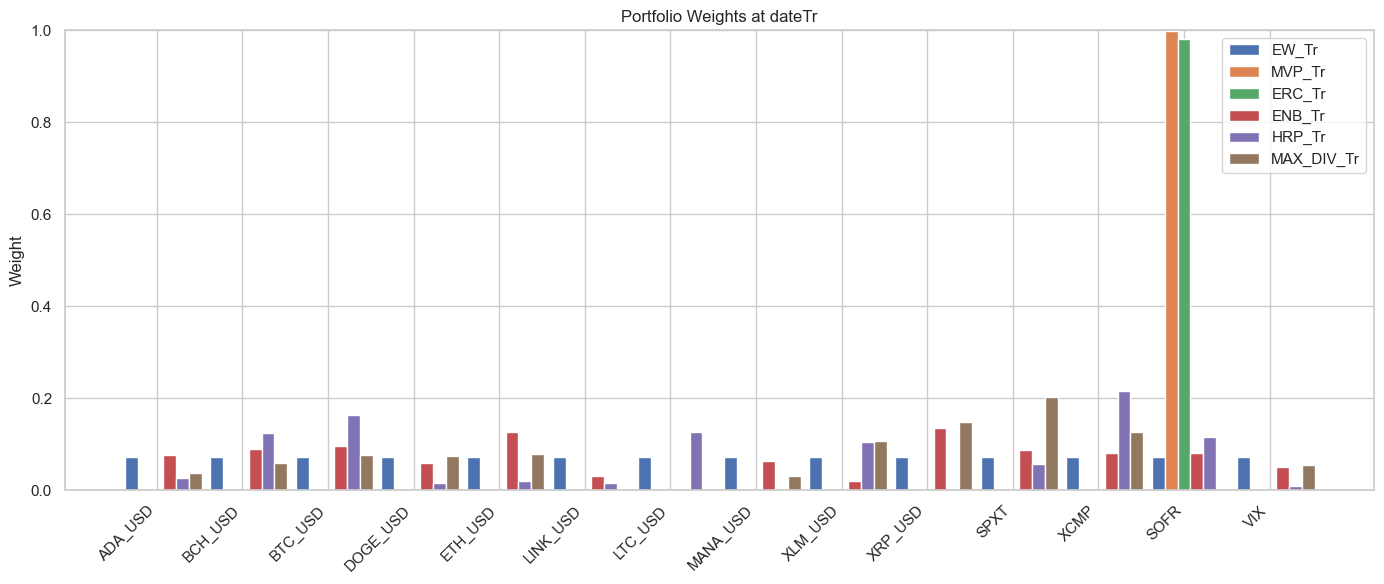

In [73]:
# List of portfolios and date suffixes
portfolios_list = ['EW', 'MVP', 'ERC', 'ENB', 'HRP', 'MAX_DIV']
assets = portfolios.index.tolist()
x = np.arange(len(assets))  # X-axis positions
width = 0.15  # width of each bar group

# --- Plot for datePP ---
fig, ax = plt.subplots(figsize=(14, 6))
for i, p in enumerate(portfolios_list):
    weights = portfolios[f"{p}_PP"]
    ax.bar(x + i*width - width*2, weights, width, label=f'{p}_PP')

ax.set_title("Portfolio Weights at datePP")
ax.set_ylabel("Weight")
ax.set_xticks(x)
ax.set_xticklabels(assets, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

# --- Plot for dateTr ---
fig, ax = plt.subplots(figsize=(14, 6))
for i, p in enumerate(portfolios_list):
    weights = portfolios[f"{p}_Tr"]
    ax.bar(x + i*width - width*2, weights, width, label=f'{p}_Tr')

ax.set_title("Portfolio Weights at dateTr")
ax.set_ylabel("Weight")
ax.set_xticks(x)
ax.set_xticklabels(assets, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

### Correlation check

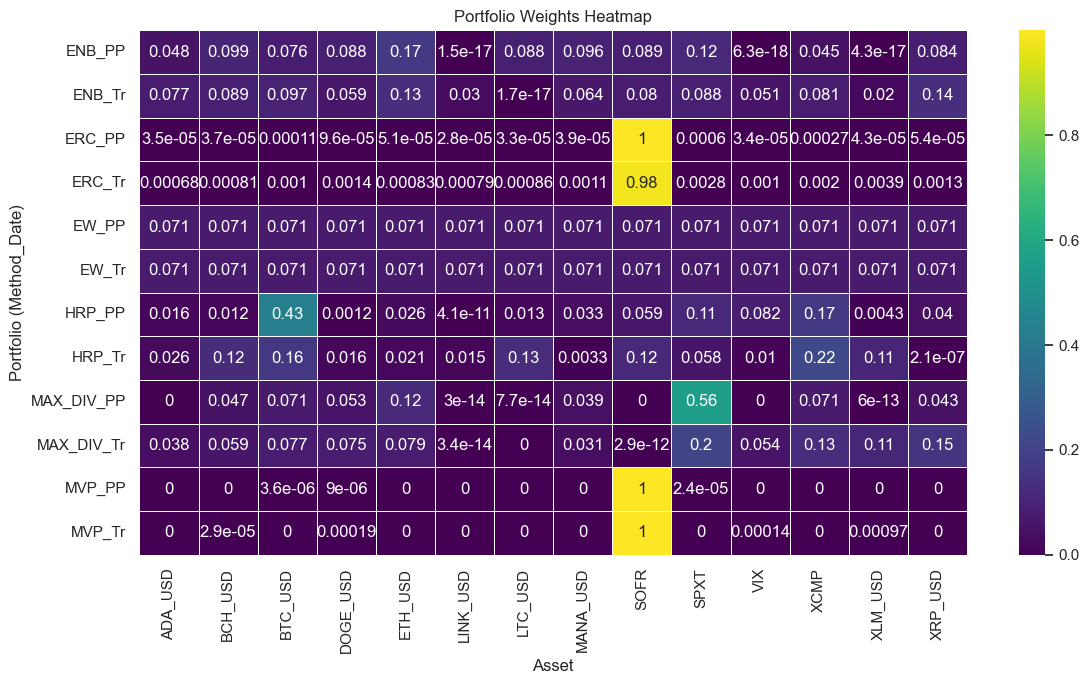

In [74]:
# Pivot for heatmap: rows = Method_Date, columns = Asset
heatmap_data = portfolios_long.pivot(index="Method_Date", columns="Asset", values="Weight")

plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", linewidths=0.5)
plt.title("Portfolio Weights Heatmap")
plt.xlabel("Asset")
plt.ylabel("Portfolio (Method_Date)")
plt.tight_layout()
plt.show()

### Plot Weights vs. Risk Contributions for Each Portfolio Type

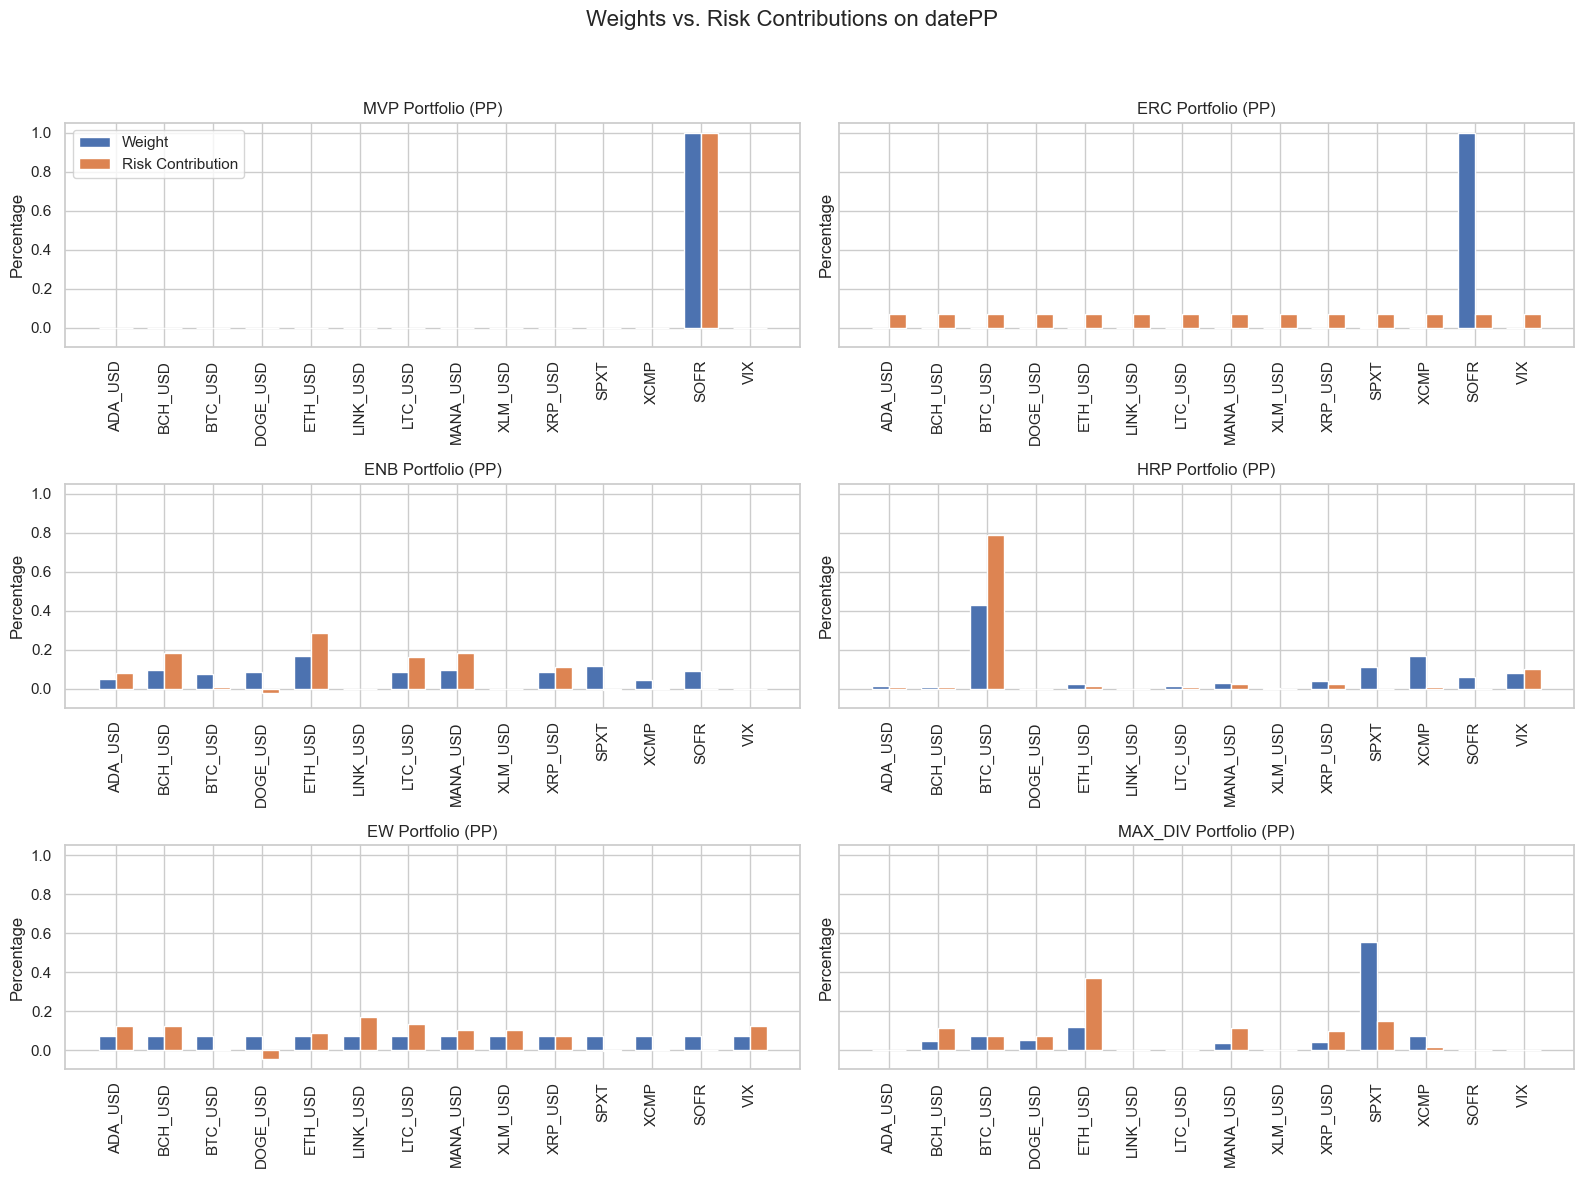

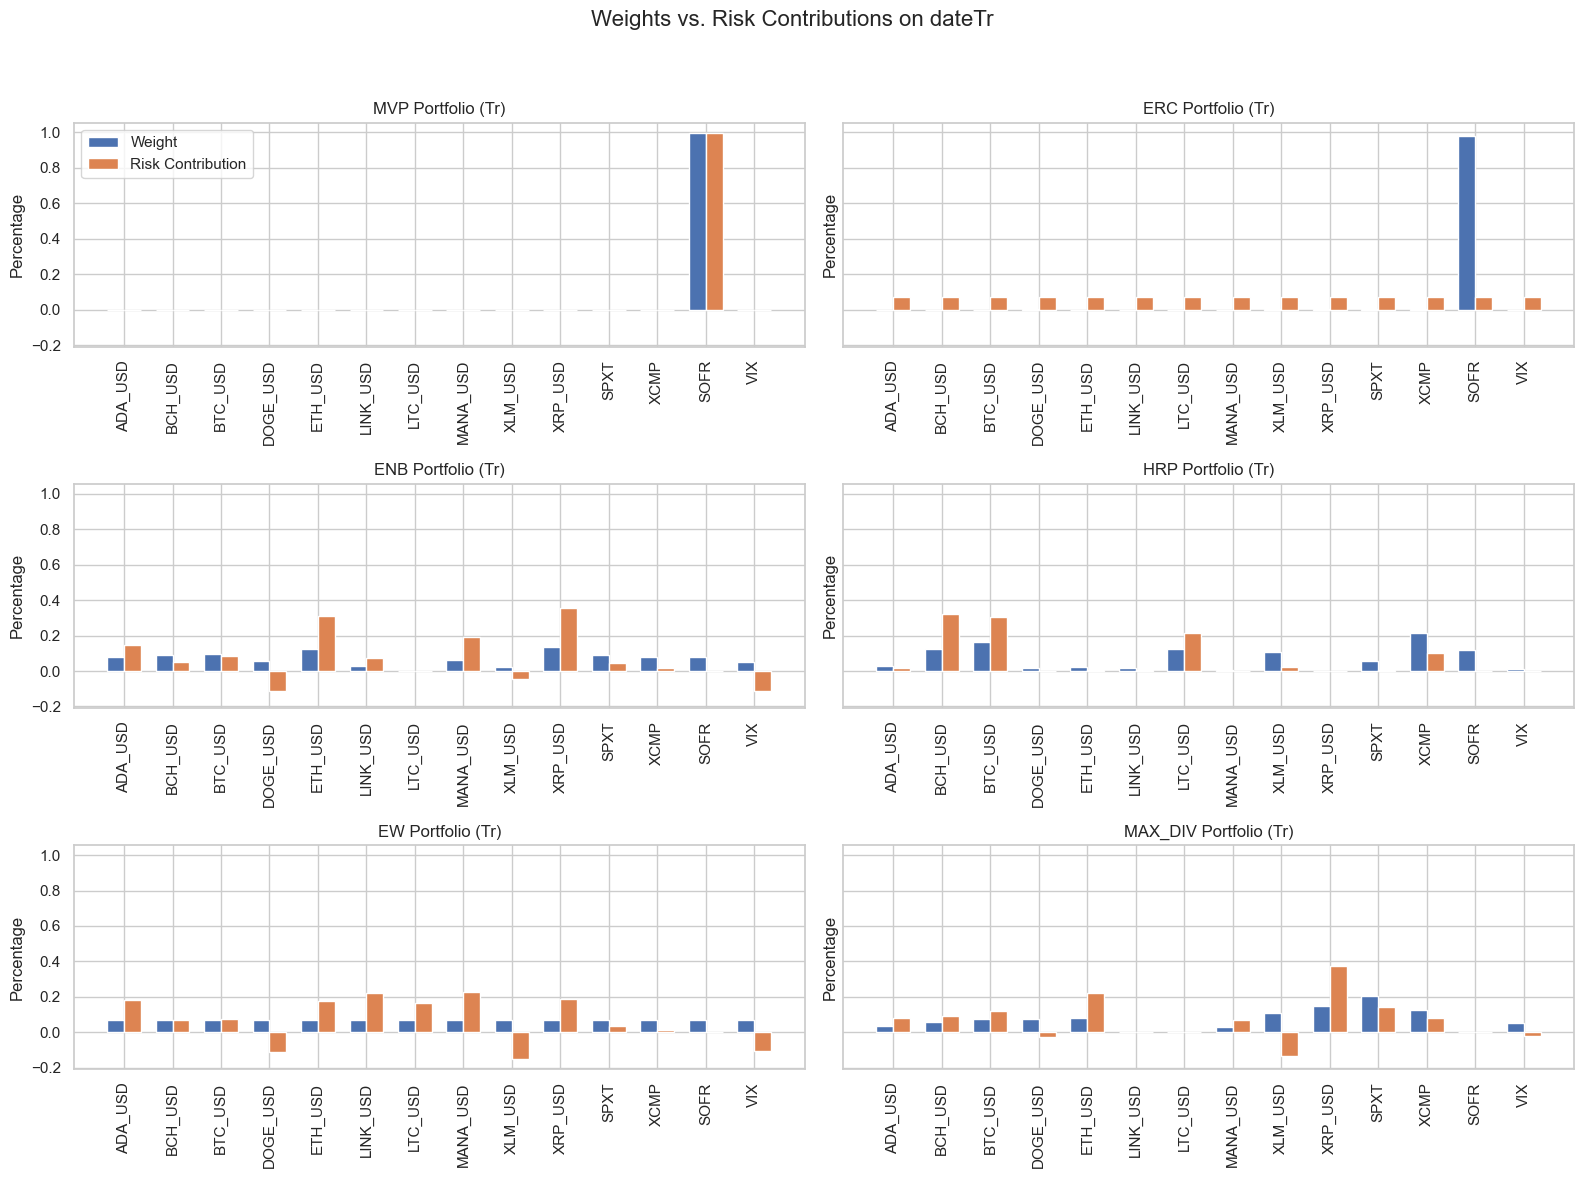

In [75]:
portfolio_types = ['MVP', 'ERC', 'ENB', 'HRP', 'EW', 'MAX_DIV']
clip_covs = {'PP': clip_cov_datePP, 'Tr': clip_cov_dateTr}
bar_width = 0.35
x = np.arange(len(portfolios.index))  # One bar group per asset

for date in ['PP', 'Tr']:
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12), sharey=True)
    axes = axes.flatten()  # Flatten to 1D array for easy indexing

    for i, pt in enumerate(portfolio_types):
        ax = axes[i]

        # Get weights and risk contributions
        weights = portfolios[f'{pt}_{date}']
        rc = compute_Euler_risk_contribution(weights, clip_covs[date], percentage=True)

        # Plot bars
        ax.bar(x - bar_width/2, weights, width=bar_width, label='Weight')
        ax.bar(x + bar_width/2, rc, width=bar_width, label='Risk Contribution')

        ax.set_title(f'{pt} Portfolio ({date})')
        ax.set_xticks(x)
        ax.set_xticklabels(portfolios.index, rotation=90)
        ax.set_ylabel('Percentage')
        ax.grid(True)
        if i == 0:
            ax.legend()

    # Hide any unused subplot (e.g., 6th slot when we have only 5 portfolios)
    if len(portfolio_types) < len(axes):
        for j in range(len(portfolio_types), len(axes)):
            fig.delaxes(axes[j])

    plt.suptitle(f'Weights vs. Risk Contributions on date{date}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Part 4: Extensions to Hierarchical Risk Parity:

### b) Solve for datePP and dateTr, and compare the weights to the standard HRP from point 3a)

In [76]:
# Compute HRP with copula-based distance at datePP
hrp_weights_PP_alt = compute_hrp_alternative(data_datePP)
print("HRP Alternative Weights at datePP (copula-based distance):")
display(hrp_weights_PP_alt.sort_values(ascending=False))

# Compute HRP with copula-based distance at dateTr
hrp_weights_Tr_alt = compute_hrp_alternative(data_dateTr)
print("HRP Alternative Weights at dateTr (copula-based distance):")
display(hrp_weights_Tr_alt.sort_values(ascending=False))

HRP Alternative Weights at datePP (copula-based distance):


SPXT        3.735524e-01
SOFR        2.554639e-01
BTC_USD     2.145335e-01
ADA_USD     3.911682e-02
XLM_USD     3.676097e-02
ETH_USD     1.755545e-02
LTC_USD     1.497043e-02
BCH_USD     1.313410e-02
XRP_USD     1.177790e-02
MANA_USD    9.713411e-03
LINK_USD    9.674603e-03
XCMP        3.674880e-03
DOGE_USD    7.162406e-05
VIX         1.833469e-10
dtype: float64

HRP Alternative Weights at dateTr (copula-based distance):


SOFR        0.693685
ADA_USD     0.084422
XCMP        0.058650
VIX         0.029990
BTC_USD     0.026853
LTC_USD     0.016929
XLM_USD     0.015493
BCH_USD     0.015463
ETH_USD     0.015427
XRP_USD     0.013265
LINK_USD    0.012042
MANA_USD    0.010880
DOGE_USD    0.006886
SPXT        0.000015
dtype: float64

In [77]:
comparison_PP = pd.DataFrame({
    "Standard HRP PP": hrp_weights_PP,
    "Alternative HRP PP": hrp_weights_PP_alt
})
display(comparison_PP)

comparison_Tr = pd.DataFrame({
    "Standard HRP Tr": hrp_weights_Tr,
    "Alternative HRP Tr": hrp_weights_Tr_alt
})
display(comparison_Tr)

Standard HRP PP  Alternative HRP PP
ADA_USD      1.581030e-02        3.911682e-02
BCH_USD      1.182773e-02        1.313410e-02
BTC_USD      4.295696e-01        2.145335e-01
DOGE_USD     1.201035e-03        7.162406e-05
ETH_USD      2.615865e-02        1.755545e-02
LINK_USD     4.125907e-11        9.674603e-03
LTC_USD      1.348141e-02        1.497043e-02
MANA_USD     3.266002e-02        9.713411e-03
XLM_USD      4.308867e-03        3.676097e-02
XRP_USD      3.960158e-02        1.177790e-02
SPXT         1.135008e-01        3.735524e-01
XCMP         1.706866e-01        3.674880e-03
SOFR         5.888373e-02        2.554639e-01
VIX          8.230963e-02        1.833469e-10

Standard HRP Tr  Alternative HRP Tr
ADA_USD      2.605731e-02            0.084422
BCH_USD      1.245360e-01            0.015463
BTC_USD      1.630836e-01            0.026853
DOGE_USD     1.583256e-02            0.006886
ETH_USD      2.076636e-02            0.015427
LINK_USD     1.509434e-02            0.012042
LTC_USD      1.257777e-01            0.016929
MANA_USD     3.251479e-03            0.010880
XLM_USD      1.051059e-01            0.015493
XRP_USD      2.082296e-07            0.013265
SPXT         5.788513e-02            0.000015
XCMP         2.153278e-01            0.058650
SOFR         1.170319e-01            0.693685
VIX          1.024971e-02            0.029990

### Comparison of plots

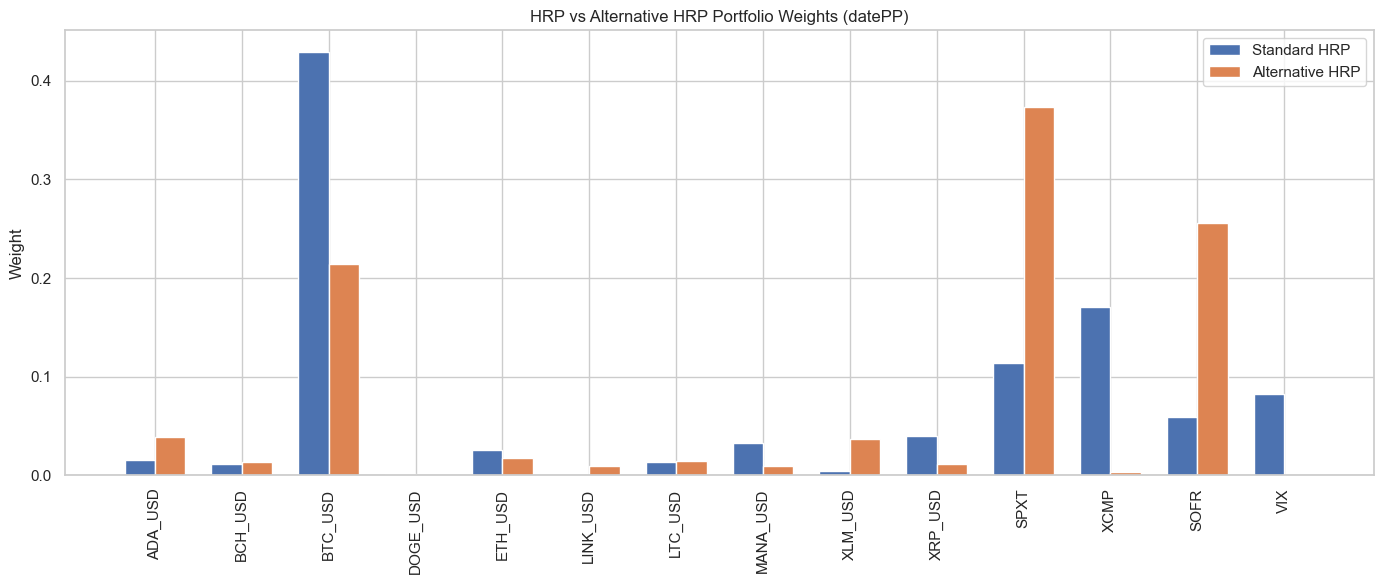

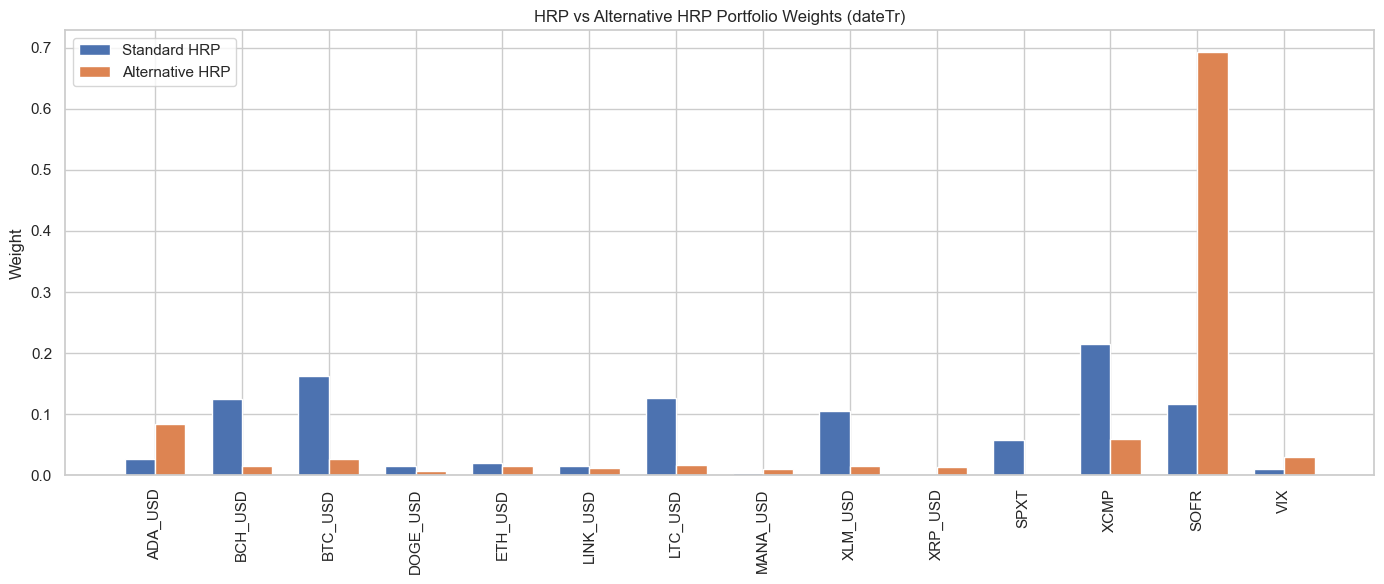

In [78]:
# Plot for datePP
plot_comparison(hrp_weights_PP, hrp_weights_PP_alt, "datePP")

# Plot for dateTr
plot_comparison(hrp_weights_Tr, hrp_weights_Tr_alt, "dateTr")

### c) Time-series momentum (TSM) signal approach

In [79]:
tsm_hrpe_weights = combine_tsm_hrpe(log_returns_cleaned, window_days=252)
print("Combined TSM + HRPe Weights:")
display(tsm_hrpe_weights.sort_values(ascending=False))

Combined TSM + HRPe Weights:


SPXT        4.178762e-01
SOFR        1.931945e-01
BTC_USD     1.799366e-01
ADA_USD     6.337924e-02
LINK_USD    5.281319e-02
XLM_USD     1.356105e-02
XRP_USD     1.283434e-02
XCMP        1.193919e-02
LTC_USD     1.015617e-03
VIX        -5.181973e-07
DOGE_USD   -8.472990e-03
MANA_USD   -9.224057e-03
BCH_USD    -1.502761e-02
ETH_USD    -2.072488e-02
dtype: float64

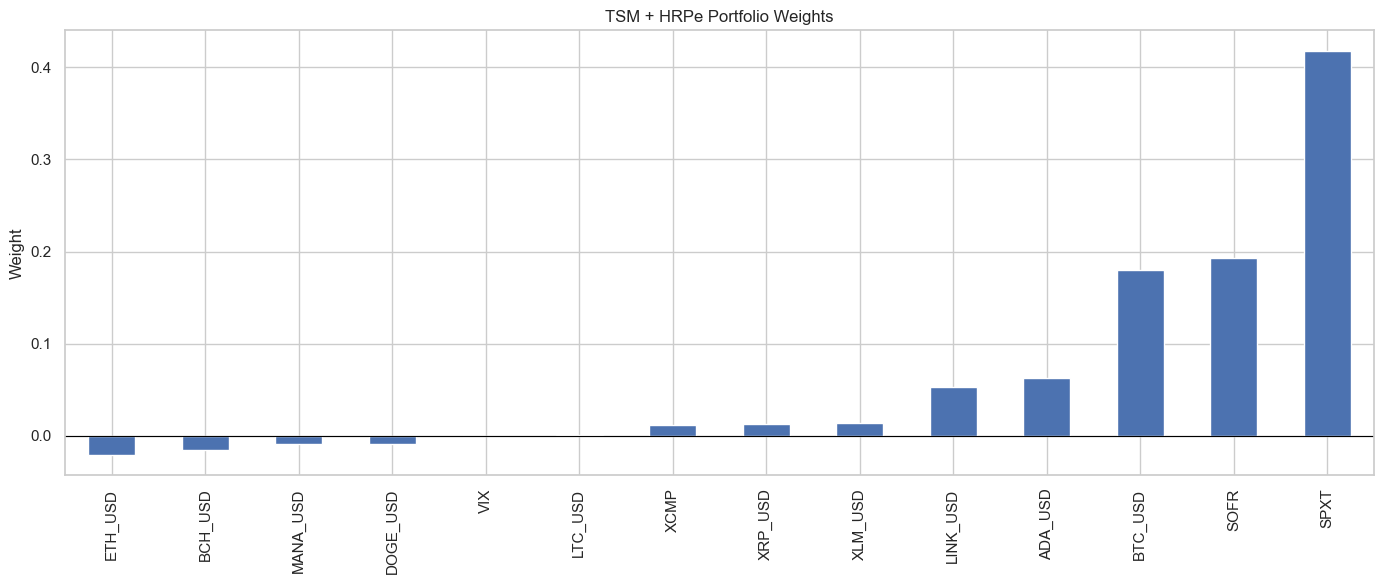

In [80]:
# Plot
plot_combined_weights(tsm_hrpe_weights)

### Backtest over full period

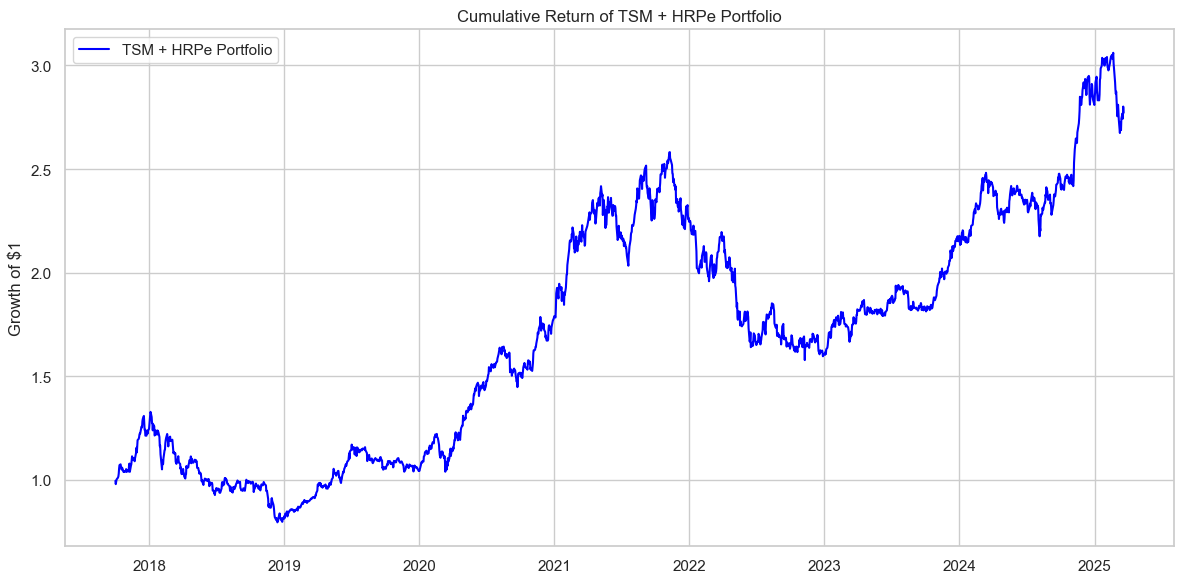

In [81]:
# Backtest over full period
cumulative_tsm_hrpe = backtest_portfolio(log_returns_cleaned, tsm_hrpe_weights)

# Plot cumulative return
plt.figure(figsize=(12, 6))
plt.plot(cumulative_tsm_hrpe, label="TSM + HRPe Portfolio", color="blue", linewidth=1.5)
plt.title("Cumulative Return of TSM + HRPe Portfolio")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [82]:
# Backtest EW portfolio
equal_weights = pd.Series(1/n_assets, index=log_returns_cleaned.columns)
cumulative_ew = backtest_portfolio(log_returns_cleaned, equal_weights)

# Compute daily returns
tsm_hrpe_daily = np.log(cumulative_tsm_hrpe / cumulative_tsm_hrpe.shift(1)).dropna()
ew_daily = np.log(cumulative_ew / cumulative_ew.shift(1)).dropna()

In [83]:
summary = pd.concat([
    summarize_performance(tsm_hrpe_daily, "TSM + HRPe"),
    summarize_performance(ew_daily, "Equal Weight")
], axis=1)

display(summary.T)

Annual Return  Annual Volatility  Sharpe Ratio
TSM + HRPe         0.132555           0.204158      0.649273
Equal Weight       0.032593           0.489234      0.066620

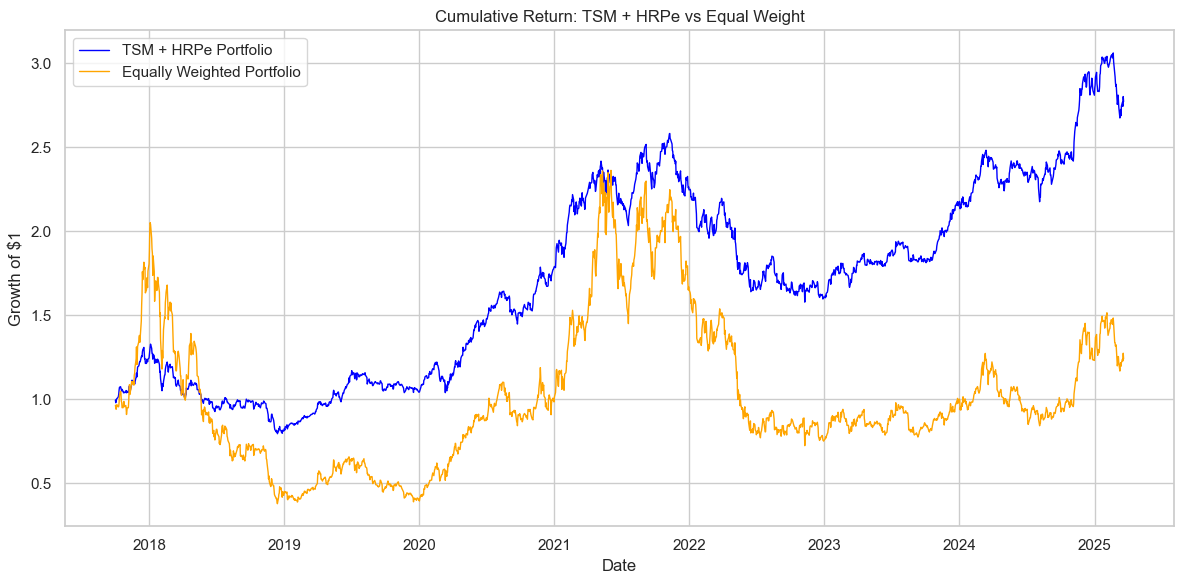

In [84]:
# n_assets = log_returns_cleaned.shape[1]
equal_weights = pd.Series(1/n_assets, index=log_returns.columns)
cumulative_ew = backtest_portfolio(log_returns_cleaned, equal_weights)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_tsm_hrpe, label="TSM + HRPe Portfolio", color="blue", linewidth=1)
plt.plot(cumulative_ew, label="Equally Weighted Portfolio", color="orange", linewidth=1)

plt.title("Cumulative Return: TSM + HRPe vs Equal Weight")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()